# 1. Imports & Definitions

Imports

In [1]:
''' imports '''

import numpy as np
import pandas as pd

from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os, re, logging

%matplotlib widget
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

import pickle, random

# density clustering using HDBSCAN* algorithm
#import hdbscan

# dimensionality reduction using UMAP
#import umap

''' torch imports '''

import torch, math

from torch import nn
from torch import optim
from torch.distributions import Normal

import glob
from PIL import Image
import matplotlib.animation as animation

import json

#import torchsde, torchcde



''' init shjnn dev env '''

# set auto reload imported modules
%load_ext autoreload
%autoreload 2

import os
# create save and gif folders if they dont exist already
if not os.path.exists('./saves/'):
    os.makedirs('./saves/')
if not os.path.exists('./gifs/'):
    os.makedirs('./gifs/')

# add location to path
import sys
sys.path.append('../libs/')

import shjnn
import time
import ffmpeg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cpu')

Dataloader


In [2]:
def dataloader(data_out):

    """
    Load raw data from file, map parameters to dimension data, compile lists of parameters, and generate full single-sample dataset.
    args: None
    returns: trajs, times, y
    """
    # decide whether to filter data before t=0
    filter = data_out['cut_zero']
    
    ## load raw data from file

    # open binary file for reading
    with open('{}/{}'.format('../run/', 'raw-full'), 'rb') as file:

        # load pickled data storage array
        db = pickle.load(file)


    ## parameter mappings to dimension data

    val_map = {
        # sample id to thickness in nm
        'thickness': {'source': 'sample',
                    '12': 160, '16': 160, '21': 160, '33': 160, '45': 160, '58': 160, },
        # intensity in uJ
        'intensity': {'source': 'int',
                    'dark': 0., '32uJ': 32., '10uJ': 10., '3uJ': 3., '1uJ': 1., '03uJ': .3},
        # voltage in V
        'voltage': {'source': 'vlt',
                    '05V': .5, '0V': 0., '15V': 1.5, '1V': 1., '2V': 2.},
        # delay time in log10(s)
        'delay': {'source': 'del',
                '100ns': 1e-7, '100us': 1e-4, '10ms': 1e-2, '10us': 1e-5, '1ms': 1e-3, '1us': 1e-6,
                '200ns': 2e-7, '200us': 2e-4, '20ms': 2e-2, '20us': 2e-5, '2ms': 2e-3, '2us': 2e-6,
                '500ns': 5e-7, '500us': 5e-4, '50ms': 5e-2, '50us': 5e-5, '5ms': 5e-3, '5us': 5e-6,
                },
    }

    ''' generate properties data '''

    # iterate nodes in database
    for node in db[:]:
        
        props = {}
        
        # iterate value mapping
        for key, value in val_map.items():
        
            # check node params for value
            if value['source'] in node['params'].keys():
                
                # map param to prop value
                props[key] = value[ node['params'][ value['source'] ] ]
                            
            else:
                # store zero for no match
                props[key] = 0.
                
        # store props in node
        node['props'] = props
    ''' generate properties data '''

    # iterate nodes in database
    for node in db[:]:
        
        props = {}
        
        # iterate value mapping
        for key, value in val_map.items():
        
            # check node params for value
            if value['source'] in node['params'].keys():
                
                # map param to prop value
                props[key] = value[ node['params'][ value['source'] ] ]
                            
            else:
                # store zero for no match
                props[key] = 0.
                
        # store props in node
        node['props'] = props

    ''' compile lists params '''

    # compile list samples
    smpls = sorted(list(set([ _['params']['sample'] for _ in db ])))
    print( 'smpls', smpls )

    # compile list voltages
    vlts = sorted(list(set([ _['props']['voltage'] for _ in db ])))
    print( 'vlts', vlts )

    # compile list voltages
    ints = sorted(list(set([ _['props']['intensity'] for _ in db ])))
    print( 'ints', ints )

    # complete list delays
    #dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::]
    # restricted delay set
    dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::3]
    print( 'dels', dels )

    
    ''' get full single-sample dataset '''

    # select transient conditions
    _smpl = '33'
    #_int = '10uJ'
    #_vlt = '15V'
    #_del = '10us'

    _db = [ n for n in db if
        n['params']['sample'] == _smpl and
        n['props']['delay'] != 0.
        #n['params']['int'] == _int and
        #n['params']['vlt'] == _vlt and
        #n['params']['del'] == _del
        ]

    print(len(_db))


    # initialise figure
    fig = plt.figure(figsize = (8,6))
    #axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(2,1)]][0]
    axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(1,1)]][0]

    # colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(_db[::10])); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'viridis')

    # zero baseline
    axs[0].plot([1e-8, 1e-4], [0,0], '--k')


    for i, n in enumerate(_db[::10]):
        
        # get time axis
        t = n['data'][:,0]
        d = n['data'][:,1]/50.
        #d0 = dark0['data'][:,1]#/50.
        #ds = d-d0

        c = smap.to_rgba(i)

        #print(light['params']['del'])

        #np.power(10,val_map['delay'][light['params']['del']])
        #sub = np.vstack([dark[:,0], (light[:,1] - dark[:,1])/50. ]).T

        #l = light['data'][:,1]#/50.
        #s = l-d

        # calculate current transient, illuminated less dark transient, voltage over 50 Ohm res
        #a = (light[:,1] - dark[:,1])/50.

        # smooth and calculate derivatives
        a = savgol_filter(x = d, window_length = 5, polyorder = 1, deriv = 0)

        _ds = 10
        
        # plot data
        axs[0].plot(t[::_ds], d[::_ds], '.', alpha = 0.2, color = c, linewidth = 2)
        axs[0].plot(t[::_ds], a[::_ds], '-', alpha = 0.44, color = c, linewidth = 1, label = ''.format())


        #axs[1].plot(t, da, '-', alpha = 0.7, color = c, linewidth = 1, label = '{}'.format(light['params']['int']))

            
    # format plots
    for i in range(len(axs)):
        axs[i].set_xscale('log')
        axs[i].set_xlim(1.0e-8, 1.0e-4)
        #axs[i].set_xlim(2.0e-7, 1.0e-4)
        
        #axs[i].set_ylim(0., 1.0e-2)
        axs[i].set_xlabel('Extraction Time (s)')
        axs[i].set_ylabel('Extracted Charge (A)')
        #axs[i].legend(title='Illumination')
        
    plt.tight_layout()
    plt.show()

    if filter:
        # filter data to only include non-zero delay times
        j = np.where(_db[0]['data'][:,0] > 2e-7)[0]

        # get log time steps, shift decay start to zero
        d = np.transpose( np.stack([ [ 
        # np.log10(n['data'][j,0][::_ds]), # time

        n['data'][j,1][::_ds]*1e2, # response, scale to ~one
        #np.log10(n['data'][j,0][::_ds])+6.6,

        #np.ones(len(ts))* np.log10(n['props']['intensity']),
        #np.ones(len(ts))* n['props']['voltage']/10,
        #np.ones(len(ts))* np.abs(np.log10(n['props']['delay']))/10,
        ]
        #for n in _db ]), (2,0,1))
        for n in _db ]), (0,2,1))
        
        # compile env. labels
        ts = np.transpose( np.stack([ [ 
            #n['data'][:,0][::_ds], # time
            #n['data'][j,0][::_ds]
            
            np.log10(n['data'][j,0][::_ds])+6.7,
        ]
        #for n in _db ]), (2,0,1))
            for n in _db ]), (0,2,1))

    else:
        j = np.where(_db[0]['data'][:,0] > 1e-9)[0]
        # get log time steps, shift decay start to zero
        #ts = np.log10(db[0]['data'][:,0][::_ds])
        ts = np.transpose( np.stack([ [ 
            #n['data'][:,0][::_ds], # time
            #n['data'][j,0][::_ds]
            
            np.log10(n['data'][j,0][::_ds])+6.7,
        ]
        #for n in _db ]), (2,0,1))
            for n in _db ]), (0,2,1))


        # stack raw data and env vars, time first
        #d = np.transpose( np.stack([ [ n['data'][:,1][::_ds], 
        d = np.transpose( np.stack([ [ 
            #np.log10(n['data'][j,0][::_ds]), # time
            
            n['data'][j,1][::_ds]*1e2, # response, scale to ~one
            #np.log10(n['data'][j,0][::_ds])+6.6,
            
        #np.ones(len(ts))* np.log10(n['props']['intensity']),
        #np.ones(len(ts))* n['props']['voltage']/10,
        #np.ones(len(ts))* np.abs(np.log10(n['props']['delay']))/10,
        ]
        #for n in _db ]), (2,0,1))
            for n in _db ]), (0,2,1))

    print(ts.shape, d.shape)

    ''' compile env. labels '''

    # stack raw data and env vars, time first
    y = np.stack([ [ 
    n['props']['intensity'],
    n['props']['voltage'],
    n['props']['delay'],
    ]
        for n in _db ])

    y.shape

    # compile trajectories, time as tensors, push to device
    trajs = torch.Tensor(d).to(device)
    times = torch.Tensor(ts).to(device)

    print(len(d), d[0].shape, ts[0].shape)

    data_out['trajs'] = trajs
    data_out['times'] = times
    data_out['y'] = y


Initialise Model

In [3]:
def init_model(model_params):
    """
        inits models - always to CPU.
        args: model_params
        return: model_params (updated)
    """
    latent_dim = model_params['latent_dim']
    nhidden = model_params['nhidden']
    rnn_nhidden = model_params['rnn_nhidden']
    obs_dim = model_params['obs_dim']
    lr = model_params['lr']
    n_batch = model_params['n_batch']

    func, rec, dec, optim, device = shjnn.init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr, device = 'cpu')
    loss: list = []
    epochs = 0
    device

    model_params['func'] = func
    model_params['rec'] = rec
    model_params['dec'] = dec
    model_params['optim'] = optim
    model_params['device'] = device
    model_params['loss'] = loss
    model_params['epochs'] = epochs
    model_params['MSE_loss'] = loss
    model_params['KL_loss'] = loss

    return model_params

Training loop

In [4]:
def training_loop(n_epochs, model_params, dataset):
    ''' run training loop with save 
        args: n_epochs, model_params, dataset
        return: model_params (updated)
    '''

    

    # beta for beta latent dissentanglement
    #beta = 4.
    # beta = .01

    # update learning rate
    # lr = 1e-3

    lr = model_params['lr']
    n_batch = model_params['n_batch']
    beta = model_params['beta']

    optim = model_params['optim']


    for g in optim.param_groups:
        g['lr'] = lr

    # get data
    trajs = dataset['trajs']
    times = dataset['times']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    device = model_params['device']

    # run training for epochs, return loss
    _epochs, _loss = shjnn.train(func, rec, dec, optim, trajs[:], times[:], n_epochs, n_batch, device, beta)

    # update loss, epochs
    model_params['loss'] += _loss
    model_params['epochs'] += _epochs

    return model_params

def done_training(model_params):
    """ check if training is done
        args: model_params
        return: bool
    """
    reach_epoch = model_params['epochs'] >= model_params['total_epochs_train']
    if len(model_params['loss']) < 10:
        reach_loss = False
    elif model_params['loss'] == None:
        reach_loss = False
    else:
        reach_loss = model_params['loss'][-1] < model_params['loss_thresh']
    return  reach_epoch or reach_loss

input adaptive update functions here

In [5]:
# parameter update functions (runs during runs and updatesand )

def update_beta(model_params, epochs):
    model_params['beta'] = model_params['beta']

def update_lr(model_params, epochs):
    model_params['lr'] = model_params['lr']

def update_n_epochs(model_params, epochs):
    return

def update_params(model_params, epochs):
    update_beta(model_params, epochs)
    update_lr(model_params, epochs)
    update_n_epochs(model_params, epochs)

Data processing and interpretation

In [6]:
def plot_training_loss(model_params, save=False, split=False):
    ''' plot training loss '''
    if split:
        MSE_loss = model_params['MSE_loss']
        KL_loss = model_params['KL_loss']

        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in MSE_loss], '-b', label = 'MSE loss', alpha = 0.3)
        ax[1].plot([_+1e1 for _ in KL_loss], '-b', label = 'KL loss', alpha = 0.3)

        # smooth loss
        train_MSE_loss = np.abs( savgol_filter(MSE_loss, 13, 3) )
        train_KL_loss = np.abs( savgol_filter(KL_loss, 13, 3) )

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in train_MSE_loss], '-b', alpha = 0.8)
        ax[1].plot([_+1e1 for _ in train_KL_loss], '-b', alpha = 0.8)


        # format and display figure
        plt.yscale('log')
        #plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph_split.png")
    else:
        # get loss
        loss = model_params['loss']

        # initialise figure
        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in loss], '-b', label = 'training loss', alpha = 0.3)

        # smooth loss
        train_loss = np.abs( savgol_filter(loss, 13, 3) )

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in train_loss], '-b', alpha = 0.8)


        # format and display figure
        plt.yscale('log')
        #plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph.png")

In [7]:
def display_random_fit(model_params, dataset, show=True, save=False, random_samples=True):
    ''' random assess model fit '''


    # get data
    trajs = dataset['trajs']
    times = dataset['times']
    y = dataset['y']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']
    

    # initialise figure
    k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
    #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
    ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]

    # generate inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select data
    j = list(range(len(trajs)))
    if random_samples:
        random.shuffle(j)

    # downsample
    j = j[::30]

    # build colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(j)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'brg')

    # iterate over transients
    for _,i in enumerate(j):
        
        # get colour
        c = smap.to_rgba(_)
        
        # send mini-batch to device
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        
        #_time = np.linspace(-7.8, -4.2, 1000)#/10
        #_time = np.linspace(-6.5+6.6, -4.2+6.6, 1000)#/10
        
        _time = np.linspace(0, 2.5, 1000)#/10
        
        #_time = np.linspace(-7., -4.2, 1000)
        #_time = np.logspace(-7.8, -4.2, 1000)
        
        #_time = np.logspace(0, 1.7, 20)
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(traj, time)

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]
        
        #print(pred_x.shape, pred_z[0,0,:])
        
        _traj = trajs[i].cpu()
        _t = times[i].cpu()

        for l in range(k):
            u = 0
            
            #ax[k].set_ylim(-.8, .8)
            sc_ = 50*1e2/1e3
            
            # plot original and predicted trajectories
            ax[l].plot(_t, _traj[:, l+u]/sc_, '.', alpha = 0.6, color = c)
            ax[l].plot(_time - 1.0, pred_x[:, l+u]/sc_, '-', label = '{:.1f} $\mu J$, {:.1f} V, {:.0e} s'.format(y[i][0], y[i][1], y[i][2]),
                    linewidth = 2, alpha = 0.4, color = c)

            
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')
    # tile includes epoch number, learning rate atnd beta
    plt.title('Epoch: {}, lr: {:.1e}, beta: {:.1e}'.format(epoch, model_params['lr'], model_params['beta']))

    #plt.xscale('log')
    plt.legend(loc='upper right', title='Intensity, Bias, Delay')

    plt.tight_layout()

    if show:
        plt.show()
    if save:
        #save as a png]
        #todo: change
        folder = model_params['folder']
        #if saves folder does not exist create it
        if not os.path.exists(folder):
            os.makedirs(folder)
        fig.savefig(folder + '/training_epoch_{}.png'.format(epoch), dpi=300)

def save_random_fit(model_params, dataset, random_samples=True):
    display_random_fit(model_params, dataset, show=False, save=True, random_samples=random_samples)

def clear_saves():
    ''' clear all save files in saves directory '''
    import os
    import glob
    #todo change??
    files = glob.glob('saves/*')
    for f in files:
        os.remove(f)

Saving and recording Data

In [8]:
def compile_learning_gif(model_params, display=True):
    # compile gif from png in saves folder
    # set read destinatino here
    folder = model_params['folder']
    glob_target = folder + '/*.png'
    print(glob_target)
    files = sorted(glob.glob(glob_target))
    image_array = []

    for my_file in files:
        
        image = Image.open(my_file)
        image_array.append(image)

    print('image_arrays shape:', np.array(image_array).shape)

    # Create the figure and axes objects
    fig, ax = plt.subplots()

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)

    def update(i):
        im.set_array(image_array[i])
        return im, 

    # Create the animation object
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

    # Show the animation
    plt.show()

    # animation_fig.save("gifs/animated_GMM.gif")

    
    # to html5 video using pillow
    if not os.path.exists(folder + "/gifs/"):
        os.makedirs(folder + "/gifs/")
    animation_fig.save(folder + "/gifs/learning_pattern.gif", writer="pillow")

    # if (display):
    #     video = animation_fig.to_html5_video()
    #     html = display.HTML(video)
    #     display.display(html) 

In [9]:
def save_model_params(model_params):
    #save model params as json file
    folder = model_params['folder']
    epoch = model_params['epochs']
    model_params_save = {
        # hyper params

        
        'nhidden': model_params['nhidden'],
        'rnn_nhidden': model_params['rnn_nhidden'],
        'obs_dim': model_params['obs_dim'],

        'latent_dim': model_params['latent_dim'],
        'lr': model_params['lr'],
        'n_batch': model_params['n_batch'],
        'beta': model_params['beta'],

        # training params
        'total_epochs_train': model_params['total_epochs_train'],
        'epochs_per_train': model_params['epochs_per_train'],
        'epochs': model_params['epochs'], # a record of the epochs
        'loss': model_params['loss'], 

        #labels
        'name': model_params['name'],
        'desc': model_params['desc'],
        'folder': model_params['folder'],
    }

    if not os.path.exists(folder + '/model'):
        os.makedirs(folder + '/model')
    with open(folder + f'/model/model_params_epoch_{epoch}.json', 'w') as fp:
        json.dump(model_params_save, fp)

def load_model_params():
    #load model params from json file
    folder = model_params['folder']
    epoch = 5   #enter your desired epoch to extract here
    with open(folder + f'/model/model_params_{epoch}.json', 'r') as fp:
        model_params = json.load(fp)
        init_model(model_params)
    return model_params

In [10]:
def save_model(model_params):
    #save model params as json file
    folder = model_params['folder']
    epoch = model_params['epochs']
    if not os.path.exists(folder + '/model'):
        os.makedirs(folder + '/model')

    # save model
    #load model params
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    loss = model_params['loss']
    epochs = model_params['epochs']
    folder = model_params['folder']
    path = folder + f'/model/save_model_ckpt_{epoch}.pth'
    shjnn.save_state(path, func, rec, dec, optim, loss, epochs)

def load_model(model_params):
    #load model params from json file. Overwrite model params.
    folder = ""
    epoch = 5   #enter your desired epoch to extract here
    path = folder + f'/model/save_model_ckpt_{epoch}.pth'
    #dev = 'gpu'
    dev = 'cpu'
    shjnn.load_state(path, model_params['func'], model_params['rec'], dec = model_params['dec'], optim = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)

In [11]:
def sweep_latent_adaptives(model_params, dataset):
    for j in range(model_params['latent_dim']):
        sweep_latent_adaptive(model_params, dataset, j)

def sweep_latent_adaptive(model_params, dataset, latent_dim_number):
    ''' get z0 prediction of complete dataset '''

    # get data
    trajs = dataset['trajs']
    times = dataset['times']
    y = dataset['y']

    #get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']
    latent_dims = model_params['latent_dim']

    # generate inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select data
    j = list(range(len(trajs)))
    #random.shuffle(j)

    Z = []

    Zz = []

    for i in j[::]:
        
        # send mini-batch to device
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        
        _time = np.linspace(0, 2.5, 1000)#/10
        
        #_time = np.linspace(-7., -4.2, 1000)
        #_time = np.logspace(-7.8, -4.2, 1000)
        
        #_time = np.logspace(0, 1.7, 20)
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(traj, time)
        
        Z.append(pred_z[0, 0, ...].detach().numpy())
        
        Zz.append(pred_z[0, ...].detach().numpy())

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]
        
    Z = np.stack(Z)
    Zz = np.stack(Zz)

    print(Z.shape, Zz.shape)

    ''' sweep latent adaptives '''

    # initialise figure
    k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
    #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
    ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]
    # setup ax for each latent dim


    # generate inference function
    #infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'latent')

    # set z dim to sweep
    j = latent_dim_number
    # for j in range(latent_dims):

    # set range over latent vector
    rr = 3
    _ = np.linspace(-rr,rr,10)

    # colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(_)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'cividis')

    # iterate over latent vector range
    for i in range(len(_)):
        _z = _[i]
        c = smap.to_rgba(i)

        # set init latent to mean of dataset or zeros
        _z0 = np.expand_dims(np.mean(Z, 0),0)
        #_z0 = np.expand_dims(np.zeros(Z.shape[-1]),0)
        
        # update latent vector for variation
        _z0[...,j] += _z
        #print(_z0)
        
        z0 = torch.Tensor(_z0).to(device)

        # define time axis
        _time = np.linspace(0, 2.5, 1000)#/10
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(z0, time)

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]

        # plot predicted trajectories
        ax[0].plot(_time, pred_x[:, 0], '-', label = 'z{}, $\mu$ {:.1f} + {:.1f}'.format(j, np.mean(Z, 0)[j],_z), alpha = 0.6, color = c, linewidth = 2)

            
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')

    plt.hlines(0., -.1, 2.6, colors = 'k', linestyle = '--', alpha = 0.5)
    plt.xlim(-.1,2.6)
            
    plt.legend()
        
    #plt.xscale('log')
    plt.tight_layout()
    plt.show()

    folder = model_params['folder']
    #if saves folder does not exist create it
    if not os.path.exists(folder + '/latent_dims'):
        os.makedirs(folder + '/latent_dims')
    fig.savefig(folder + f'/latent_dims/epoch_{epoch}_dim_{latent_dim_number}.png', dpi=300)

Run the train & test

In [12]:
def run_and_save(model_params, dataset, grid_search=False, grid_search_name="default"):

    import time

    print('The model parameters are: ' + str(model_params))

    name = model_params['name']
    desc = model_params['desc']

    #replace all spaces with _
    name = name.replace(" ", "_")
    desc = desc.replace(" ", "_")

    # create folder based on time, name and description
    timestr = time.strftime("%Y%m%d-%H%M%S")
    folder = './saves/' + desc + '_' + name + '_' + timestr
    if grid_search:
        folder = f'./saves/grid_seach/{grid_search_name}/' + desc + '_' + name + '_' + timestr
        #make parent dirs
        # if not os.path.exists(f'./saves/grid_seach'):
        #     os.makedirs(f'./saves/grid_seach')
        # if not os.path.exists(f'./saves/grid_seach/{grid_search_name}'):
        #     os.makedirs(f'./saves/grid_seach/{grid_search_name}')
    model_params['folder'] = folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    train_epochs = model_params['epochs_per_train']
    init_model(model_params)
    while not done_training(model_params):
        training_loop(train_epochs, model_params, dataset)
        print("epochs printout:   ")
        print(model_params['epochs'])
        print("loss printout: ")
        print(model_params['loss'])
        update_params(model_params, model_params['epochs'])
        save_random_fit(model_params, dataset, random_samples=False)
        save_model(model_params)
        plot_training_loss(model_params, save=True)
    save_model_params(model_params)
    compile_learning_gif(model_params, display=False)

    return model_params

def grid_search(model_params):
    learning_rates = [1e-2]
    n_batches = [16]
    latent_dims = [2]
    betas = [4]


    # beta never above 4  done
    # latent_dims : 1, 2, 4, 8, 16   done
    # learning rats: 1e-2, 5e-3, 1e-3, 5e-4, 1e-4    done
    # ode solver struggles to "converge" when its already close. implement time/loss wrapper that stops the running when reached and output what epoch it reached the limit.

    #check both MSE and KL. KL should be around 1, MSE is dependent on the data. Try to normalise MSE so that it is around KL. feat. loss is MSE
    # check if kl loss is before or after beta.
    # could plot the KL loss and the MSE loss on the same graph to compare and see how its training.

    # add training gif for each run. done
    # save model checkpoints.   done
    

    # learning_rates = [5e-3, 1e-3]
    # n_batches = [16]
    # latent_dims = [8]
    # betas = [.001, 4,]

    run_description = "search2"

    data_record = {"learning rate": [],
                    "n_batch": [],
                    "latent_dim": [],
                    "beta": [],
                    "lowest_loss": []}
    
    loss_record = {"learning rate": [],
                   "n_batch": [],
                   "latent_dim": [],
                   "beta": [],
                   "loss": []}

    total_runs = len(learning_rates) * len(n_batches) * len(latent_dims) * len(betas)
    excel_folder_created = False
    excel_folder_path = ""

    
    for lr in learning_rates:
        for n_batch in n_batches:
            for latent_dim in latent_dims:
                for beta in betas:
                    model_params['lr'] = lr
                    model_params['n_batch'] = n_batch
                    model_params['latent_dim'] = latent_dim
                    model_params['beta'] = beta
                    model_params['desc'] = f"lr_{lr}_nb_{n_batch}_ld_{latent_dim}_b_{beta}"

                    try:
                        run_and_save(model_params, dataset, grid_search=True, grid_search_name=run_description)
                    except AssertionError:
                        model_params["loss"].append(-1)
                    # handle assertion error
                    

                    #write summary data to excel sheet
              

                    

                    # append information to data_record
                    data_record["learning rate"].append(lr)
                    data_record["n_batch"].append(n_batch)
                    data_record["latent_dim"].append(latent_dim)
                    data_record["beta"].append(beta)
                    loss = model_params['loss']
                    lowest_loss = min(loss)
                    data_record["lowest_loss"].append(lowest_loss)

                    # append information to loss_record
                    loss_record["learning rate"].append(lr)
                    loss_record["n_batch"].append(n_batch)
                    loss_record["latent_dim"].append(latent_dim)
                    loss_record["beta"].append(beta)
                    loss_record["loss"].append(loss)

                    model_params["epochs"] = 0
                    model_params["loss"] = 0

    if not excel_folder_created:
    #create excel sheet
        folder = model_params['folder']
        excel_folder_path = f'{folder}/../excel_output'
        if not os.path.exists(excel_folder_path):
            os.makedirs(excel_folder_path)
        excel_folder_created = True

    #write to excel
    df = pd.DataFrame(data_record)
    sheet = pd.ExcelWriter(f'{excel_folder_path}/summary.xlsx')
    df.to_excel(sheet)
    sheet.close()

    lf = pd.DataFrame(loss_record)
    loss_sheet = pd.ExcelWriter(f'{excel_folder_path}/loss_record.xlsx')
    lf.to_excel(loss_sheet)
    loss_sheet.close()
    
def display_random_fit(model_params, dataset, show=True, save=False, random_samples=True):
    ''' random assess model fit '''

    # get data
    trajs = dataset['trajs']
    times = dataset['times']
    y = dataset['y']
    filter = dataset['cut_zero']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']


    # initialise figure
    k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
    #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
    ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]

    # generate inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select data
    j = list(range(len(trajs)))
    if random_samples:
        random.shuffle(j)

    # downsample
    j = j[::30]

    # build colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(j)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'brg')

    # iterate over transients
    for _,i in enumerate(j):
        
        # get colour
        c = smap.to_rgba(_)
        
        # send mini-batch to device
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        
        #_time = np.linspace(-7.8, -4.2, 1000)#/10
        #_time = np.linspace(-6.5+6.6, -4.2+6.6, 1000)#/10
        
        _time = np.linspace(0, 2.5, 1000)#/10
        
        #_time = np.linspace(-7., -4.2, 1000)
        #_time = np.logspace(-7.8, -4.2, 1000)
        
        #_time = np.logspace(0, 1.7, 20)
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(traj, time)

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]
        
        #print(pred_x.shape, pred_z[0,0,:])
        
        _traj = trajs[i].cpu()
        _t = times[i].cpu()

        for l in range(k):
            u = 0
            
            #ax[k].set_ylim(-.8, .8)
            sc_ = 50*1e2/1e3
            
            # plot original and predicted trajectories
            ax[l].plot(_t, _traj[:, l+u]/sc_, '.', alpha = 0.6, color = c)
            if filter:
                ax[l].plot(_time, pred_x[:, l+u]/sc_, '-', label = '{:.1f} $\mu J$, {:.1f} V, {:.0e} s'.format(y[i][0], y[i][1], y[i][2]), linewidth = 2, alpha = 0.4, color = c)
            else:
                ax[l].plot(_time - 1.0, pred_x[:, l+u]/sc_, '-', label = '{:.1f} $\mu J$, {:.1f} V, {:.0e} s'.format(y[i][0], y[i][1], y[i][2]),
                    linewidth = 2, alpha = 0.4, color = c)

            
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')
    # tile includes epoch number, learning rate atnd beta
    plt.title('Epoch: {}, lr: {:.1e}, beta: {:.1e}'.format(epoch, model_params['lr'], model_params['beta']))

    #plt.xscale('log')
    plt.legend(loc='upper right', title='Intensity, Bias, Delay')

    plt.tight_layout()

    if show:
        plt.show()
    if save:
        #save as a png
        #todo: change
        folder = model_params['folder']
        #if saves folder does not exist create it
        if not os.path.exists(folder):
            os.makedirs(folder)
        fig.savefig(folder + '/training_epoch_{}.png'.format(epoch), dpi=300)

def adaptive_run_and_save(model_params, dataset, adaptive_training):
    ''' run and save model with adaptive training '''
    # print out hte adaptive_training parameters
    print('The adaptive training parameters are: ' + str(adaptive_training))

    # extract the epochs
    epochs_list = adaptive_training['epochs']
    # extract the learning rates
    lr_list = adaptive_training['lr']
    # extract the beta
    beta_list = adaptive_training['beta']

    # initialization
    name = model_params['name']
    desc = 'adaptive run'

    #replace all spaces with _
    name = name.replace(" ", "_")
    desc = desc.replace(" ", "_")

    # create folder based on time, name and description
    timestr = time.strftime("%Y%m%d-%H%M%S")
    folder = './saves/' + desc + '_' + name + '_' + timestr
    model_params['folder'] = folder
    if not os.path.exists(folder):
        os.makedirs(folder)
    init_model(model_params)

    # define cumulative epoch counts for plotting
    cumulative_epochs = np.cumsum(epochs_list)
    # plot the lr and beta as a function of epoch
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].plot(cumulative_epochs, lr_list, '-o')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Learning Rate')
    ax[1].plot(cumulative_epochs, beta_list, '-o')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Beta')
    # save the figure
    folder = model_params['folder']
    save_folder = f"{folder}/adaptive_parameters/"
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(f"{save_folder}/adaptive_parameters.png")
    plt.show()

    # for each epoch, learning rate and beta, run the model and save
    for k in range(len(epochs_list)):

        # update the model parameters
        model_params['lr'] = lr_list[k]
        model_params['beta'] = beta_list[k]
        train_epochs = epochs_list[k]
        update_params(model_params, model_params['epochs'])
        
        # conduct training
        training_loop(train_epochs, model_params, dataset)
        print("epochs printout:   ")
        print(model_params['epochs'])
        print("loss printout: ")
        print(model_params['loss'])
        update_params(model_params, model_params['epochs'])
        save_random_fit(model_params, dataset, random_samples=False)
        save_model(model_params)
        save_model_params(model_params)
        plot_training_loss(model_params, save=True, split=True)
        compile_learning_gif(model_params, display=False)

        # check if the training is done
        if done_training(model_params):
            break

        

# 2. Define parameters

Main

- always run #configure initial state here!

smpls ['12', '16', '21', '33', '45', '58']
vlts [0.0, 0.5, 1.0, 1.5, 2.0]
ints [0.0, 0.3, 1.0, 3.0, 10.0, 32.0]
dels [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01]
150


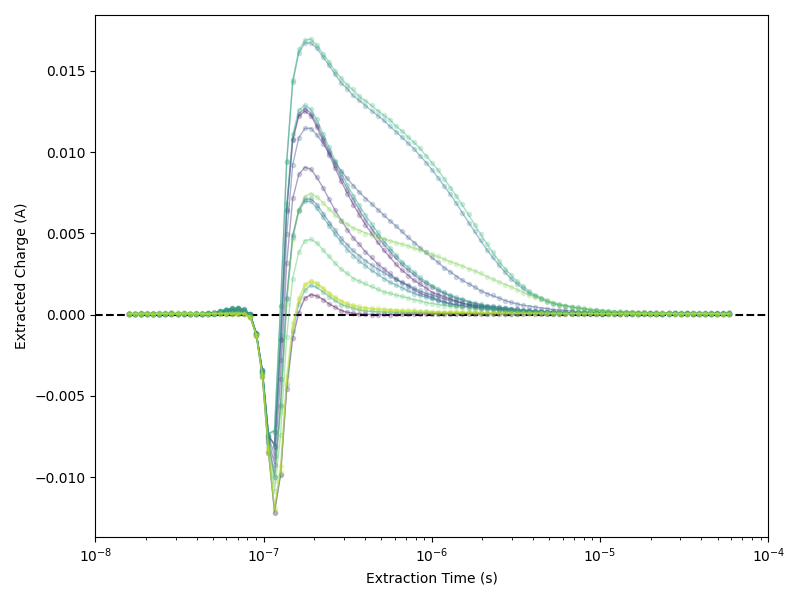

(150, 70, 1) (150, 70, 1)
150 (70, 1) (70, 1)


In [14]:
# configure initial state here.


# dictionary of hyper params
dataset = {
    'trajs': None,
    'times': None,
    'y': None,
    'cut_zero': True # whether to delete all data before t=0
}

model_params = {
    # hyper params

    
    'nhidden': 128,
    'rnn_nhidden': 32,
    'obs_dim': 1,

    'latent_dim': 16,
    'lr': 1e-2,
    'n_batch': 16,
    'beta': 4,

    'optim': None,
    'device': None,
    'func': None,
    'rec': None,
    'dec': None,

    # training params
    'total_epochs_train': 1000,
    'epochs_per_train': 50,
    'epochs': 0, # a record of the epochs
    'loss': 0,
    'loss_thresh': 0,

    #labels
    'name': "default",
    'desc': "default run",
    'folder': "saves"
}

amp = 2
freq = 1
adaptive_training = {
    # change the training parameters during the training procedure, all lists has to have the same length.
    'lr': np.logspace(-2, -3, 20),
    'beta': amp*np.sin(np.linspace(0, 5/2*np.pi, 20)) + 2,
    'epochs': [2]*20
}

dataloader(dataset)
trajs = dataset['trajs']

obs_dim = trajs[0].size()[1]
model_params['obs_dim'] = obs_dim
# latent_dim, nhidden, rnn_nhidden, obs_dim, lr, n_batch, beta = get_hyper_params(trajs)
# model_params = get_hyper_params(dataset, model_params)
# # func, rec, dec, optim, device, loss, epochs = init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr)
# model_params = init_model(model_params)
# training_loop(func, rec, dec, optim, trajs, times, n_batch, device, beta)

#clear saves folder
# clear_saves()

# 3.Vanilla way of running code

## 3.1. Execute adaptive training

The adaptive training parameters are: {'lr': array([0.01      , 0.00885867, 0.0078476 , 0.00695193, 0.00615848,
       0.00545559, 0.00483293, 0.00428133, 0.00379269, 0.00335982,
       0.00297635, 0.00263665, 0.00233572, 0.00206914, 0.00183298,
       0.00162378, 0.00143845, 0.00127427, 0.00112884, 0.001     ]), 'beta': array([2.        , 2.80339085, 3.47144782, 3.89163448, 3.99316899,
       3.7589475 , 3.22842543, 2.49097097, 1.67081082, 0.90610368,
       0.32566704, 0.02727739, 0.06119947, 0.42171898, 1.04810521,
       1.83484131, 2.64939894, 3.35456314, 3.83154665, 4.        ]), 'epochs': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}
intialising model on device: cpu


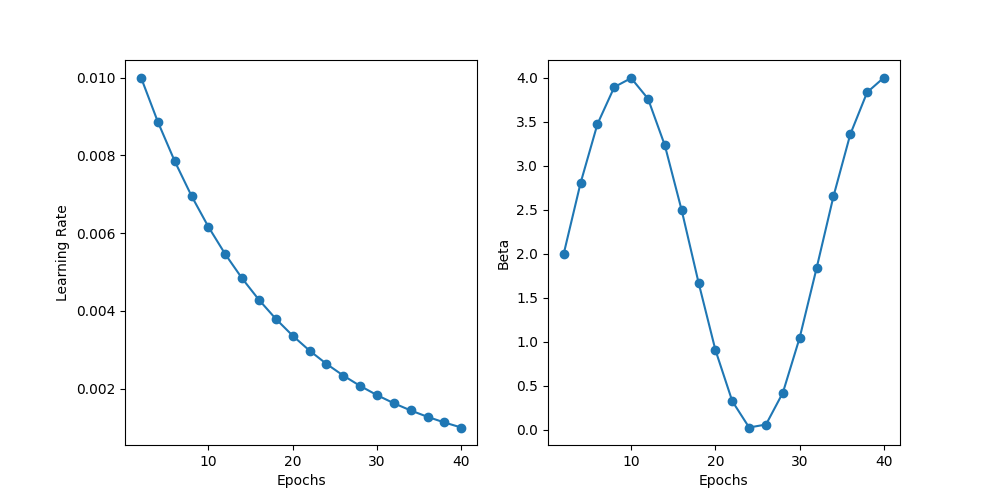

Epoch 1: Total Loss 103960.789, KL Loss 3.27, Feat. Loss 103954.25
Epoch 1: Total Loss 133224.531, KL Loss 3.55, Feat. Loss 133217.44
Epoch 1: Total Loss 97125.266, KL Loss 5.10, Feat. Loss 97115.05
Epoch 1: Total Loss 89823.102, KL Loss 8.77, Feat. Loss 89805.55
Epoch 1: Total Loss 97030.961, KL Loss 14.24, Feat. Loss 97002.47
Epoch 1: Total Loss 58844.102, KL Loss 19.80, Feat. Loss 58804.52
Epoch 1: Total Loss 55684.391, KL Loss 28.92, Feat. Loss 55626.56
Epoch 1: Total Loss 60191.680, KL Loss 37.98, Feat. Loss 60115.72
Epoch 1: Total Loss 52961.664, KL Loss 49.71, Feat. Loss 52862.24
Epoch 1 : 4992.31, 5613.94
Epoch 2: Total Loss 37107.492, KL Loss 58.79, Feat. Loss 36989.91
Epoch 2: Total Loss 49261.332, KL Loss 71.21, Feat. Loss 49118.92
Epoch 2: Total Loss 20120.734, KL Loss 73.89, Feat. Loss 19972.96
Epoch 2: Total Loss 14404.931, KL Loss 57.73, Feat. Loss 14289.46
Epoch 2: Total Loss 20017.029, KL Loss 65.60, Feat. Loss 19885.84
Epoch 2: Total Loss 8266.428, KL Loss 58.99, Feat

ValueError: too many values to unpack (expected 2)

In [15]:
adaptive_run_and_save(model_params, dataset, adaptive_training)

## 3.2. Execute a grid search

The model parameters are: {'nhidden': 128, 'rnn_nhidden': 32, 'obs_dim': 1, 'latent_dim': 2, 'lr': 0.01, 'n_batch': 16, 'beta': 4, 'optim': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), 'device': 'cpu', 'func': LatentODEfunc(
  (elu): ELU(alpha=1.0, inplace=True)
  (fci): Linear(in_features=16, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fco): Linear(in_features=128, out_features=16, bias=True)
), 'rec': RecognitionRNN(
  (i2h): Linear(in_features=33, out_features=32, bias=True)
  (h2o): Linear(in_features=32, out_features=32, bias=True)
), 'dec': Decoder(
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
), 'total_epochs_train': 5, 'epochs_per_train': 1, 'epochs': 5

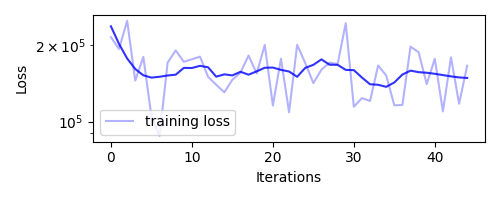

./saves/grid_seach/search2/lr_0.01_nb_16_ld_2_b_4_default_20240220-144401/*.png
image_arrays shape: (5, 1200, 2100, 4)


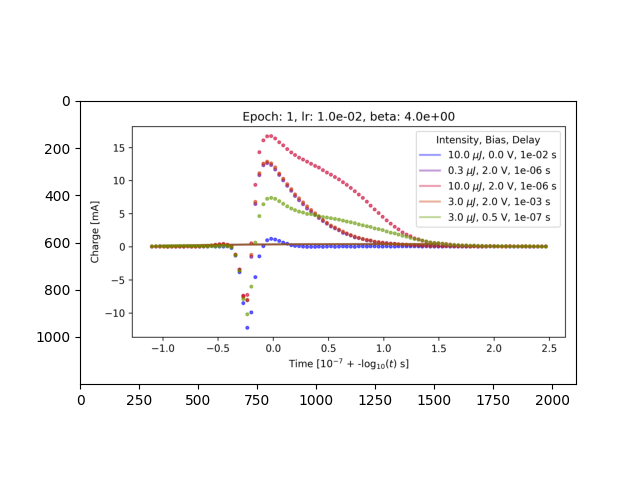

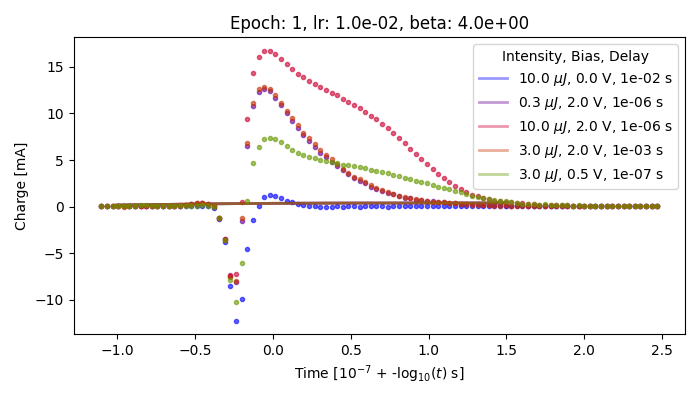

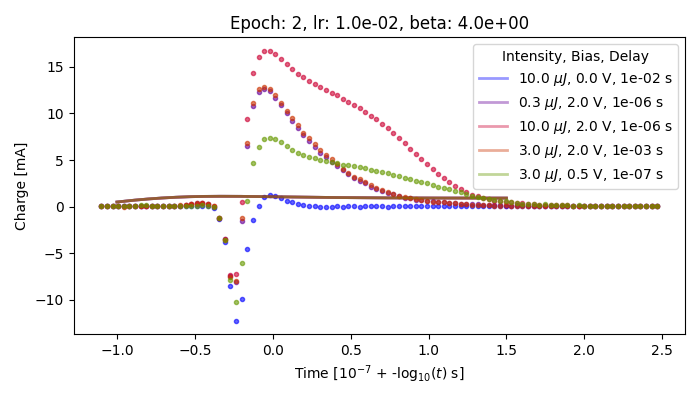

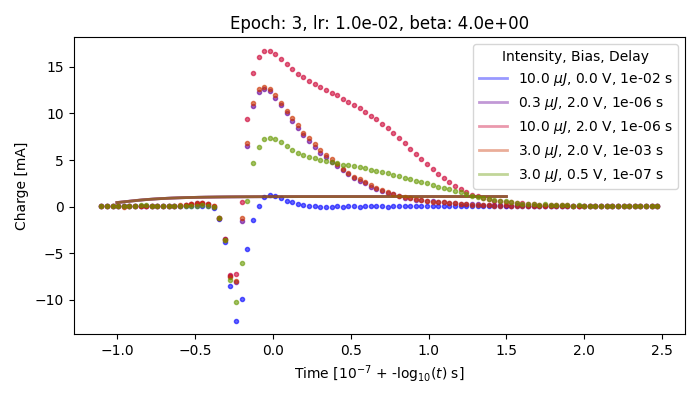

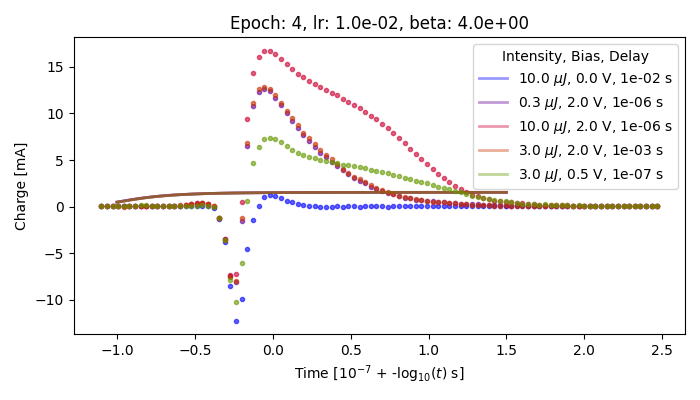

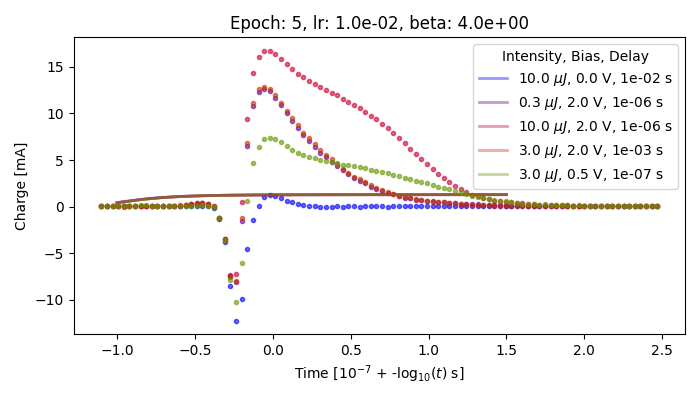

In [27]:
grid_search(model_params)

## 3.3. Run and save

The model parameters are: {'nhidden': 128, 'rnn_nhidden': 32, 'obs_dim': 1, 'latent_dim': 16, 'lr': 0.01, 'n_batch': 16, 'beta': 4, 'optim': None, 'device': None, 'func': None, 'rec': None, 'dec': None, 'total_epochs_train': 1000, 'epochs_per_train': 50, 'epochs': 0, 'loss': 0, 'loss_thresh': 1000, 'name': 'default', 'desc': 'default run', 'folder': 'saves'}
intialising model on device: cpu
Epoch 1: Total Loss 90654.742, KL Loss 2.08, Feat. Loss 90646.43
Epoch 1: Total Loss 109973.703, KL Loss 3.85, Feat. Loss 109958.30
Epoch 1: Total Loss 107539.586, KL Loss 7.44, Feat. Loss 107509.81
Epoch 1: Total Loss 92536.250, KL Loss 11.39, Feat. Loss 92490.69
Epoch 1: Total Loss 102228.883, KL Loss 17.43, Feat. Loss 102159.17
Epoch 1: Total Loss 62545.461, KL Loss 24.39, Feat. Loss 62447.90
Epoch 1: Total Loss 65066.945, KL Loss 35.39, Feat. Loss 64925.40
Epoch 1: Total Loss 35370.855, KL Loss 40.98, Feat. Loss 35206.91
Epoch 1: Total Loss 67411.953, KL Loss 63.33, Feat. Loss 67158.63
Epoch 1 :

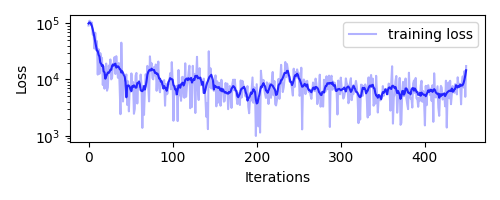

Epoch 1: Total Loss 4479.472, KL Loss 53.20, Feat. Loss 4266.67
Epoch 1: Total Loss 6936.426, KL Loss 64.47, Feat. Loss 6678.57
Epoch 1: Total Loss 10719.342, KL Loss 80.70, Feat. Loss 10396.54
Epoch 1: Total Loss 2570.273, KL Loss 69.82, Feat. Loss 2290.99
Epoch 1: Total Loss 11562.992, KL Loss 74.00, Feat. Loss 11267.00
Epoch 1: Total Loss 4216.820, KL Loss 59.79, Feat. Loss 3977.64
Epoch 1: Total Loss 4164.837, KL Loss 52.44, Feat. Loss 3955.06
Epoch 1: Total Loss 3626.299, KL Loss 56.54, Feat. Loss 3400.15
Epoch 1: Total Loss 10511.397, KL Loss 66.68, Feat. Loss 10244.69
Epoch 1 : 391.92, 279.97
Epoch 2: Total Loss 10514.507, KL Loss 77.61, Feat. Loss 10204.05
Epoch 2: Total Loss 5690.392, KL Loss 65.20, Feat. Loss 5429.59
Epoch 2: Total Loss 6949.135, KL Loss 63.11, Feat. Loss 6696.68
Epoch 2: Total Loss 4103.047, KL Loss 65.32, Feat. Loss 3841.77
Epoch 2: Total Loss 2551.624, KL Loss 56.47, Feat. Loss 2325.76
Epoch 2: Total Loss 5767.733, KL Loss 48.16, Feat. Loss 5575.09
Epoch 2

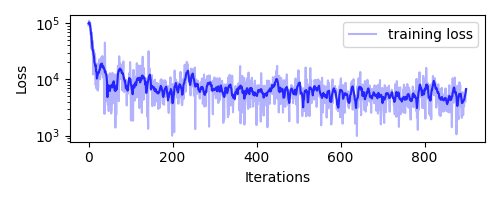

Epoch 1: Total Loss 10007.350, KL Loss 51.55, Feat. Loss 9801.15
Epoch 1: Total Loss 5169.880, KL Loss 43.84, Feat. Loss 4994.50
Epoch 1: Total Loss 6755.217, KL Loss 62.30, Feat. Loss 6506.03
Epoch 1: Total Loss 4251.376, KL Loss 53.46, Feat. Loss 4037.53
Epoch 1: Total Loss 4708.312, KL Loss 59.17, Feat. Loss 4471.62
Epoch 1: Total Loss 3748.360, KL Loss 49.99, Feat. Loss 3548.41
Epoch 1: Total Loss 8220.780, KL Loss 55.90, Feat. Loss 7997.19
Epoch 1: Total Loss 11874.363, KL Loss 37.26, Feat. Loss 11725.34
Epoch 1: Total Loss 10805.709, KL Loss 40.28, Feat. Loss 10644.58
Epoch 1 : 436.94, 422.20
Epoch 2: Total Loss 4762.622, KL Loss 53.02, Feat. Loss 4550.53
Epoch 2: Total Loss 1916.989, KL Loss 41.09, Feat. Loss 1752.64
Epoch 2: Total Loss 4270.238, KL Loss 38.39, Feat. Loss 4116.69
Epoch 2: Total Loss 3393.065, KL Loss 55.12, Feat. Loss 3172.60
Epoch 2: Total Loss 5896.827, KL Loss 65.77, Feat. Loss 5633.76
Epoch 2: Total Loss 10722.262, KL Loss 53.79, Feat. Loss 10507.12
Epoch 2:

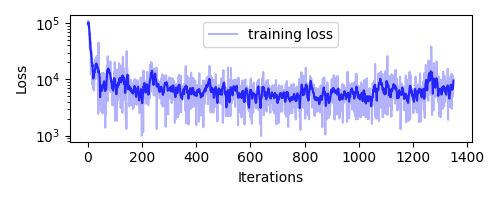

Epoch 1: Total Loss 11151.114, KL Loss 80.49, Feat. Loss 10829.16
Epoch 1: Total Loss 10540.455, KL Loss 62.09, Feat. Loss 10292.09
Epoch 1: Total Loss 4662.680, KL Loss 46.68, Feat. Loss 4475.95
Epoch 1: Total Loss 7014.013, KL Loss 79.65, Feat. Loss 6695.41
Epoch 1: Total Loss 1958.733, KL Loss 51.27, Feat. Loss 1753.65
Epoch 1: Total Loss 2593.818, KL Loss 44.36, Feat. Loss 2416.37
Epoch 1: Total Loss 12565.270, KL Loss 53.30, Feat. Loss 12352.06
Epoch 1: Total Loss 9776.762, KL Loss 43.34, Feat. Loss 9603.40
Epoch 1: Total Loss 3219.202, KL Loss 34.84, Feat. Loss 3079.86
Epoch 1 : 423.21, 438.38
Epoch 2: Total Loss 8015.811, KL Loss 50.24, Feat. Loss 7814.85
Epoch 2: Total Loss 6479.378, KL Loss 65.93, Feat. Loss 6215.68
Epoch 2: Total Loss 3679.492, KL Loss 48.09, Feat. Loss 3487.14
Epoch 2: Total Loss 5654.615, KL Loss 58.86, Feat. Loss 5419.19
Epoch 2: Total Loss 6692.048, KL Loss 63.69, Feat. Loss 6437.29
Epoch 2: Total Loss 4094.188, KL Loss 46.29, Feat. Loss 3909.02
Epoch 2: 

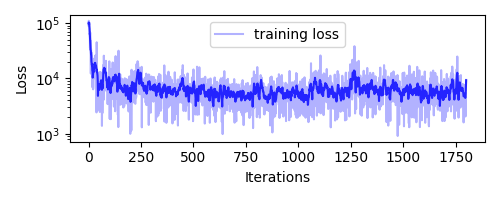

Epoch 1: Total Loss 5193.888, KL Loss 42.83, Feat. Loss 5022.55
Epoch 1: Total Loss 3175.968, KL Loss 28.59, Feat. Loss 3061.61
Epoch 1: Total Loss 3796.844, KL Loss 47.32, Feat. Loss 3607.55
Epoch 1: Total Loss 2620.647, KL Loss 37.66, Feat. Loss 2470.00
Epoch 1: Total Loss 2875.966, KL Loss 36.89, Feat. Loss 2728.39
Epoch 1: Total Loss 9150.834, KL Loss 60.34, Feat. Loss 8909.48
Epoch 1: Total Loss 6538.053, KL Loss 39.65, Feat. Loss 6379.45
Epoch 1: Total Loss 6171.609, KL Loss 45.26, Feat. Loss 5990.55
Epoch 1: Total Loss 6584.836, KL Loss 48.88, Feat. Loss 6389.31
Epoch 1 : 307.39, 324.62
Epoch 2: Total Loss 7429.847, KL Loss 46.29, Feat. Loss 7244.71
Epoch 2: Total Loss 4927.322, KL Loss 41.79, Feat. Loss 4760.17
Epoch 2: Total Loss 6557.174, KL Loss 50.67, Feat. Loss 6354.51
Epoch 2: Total Loss 4683.200, KL Loss 40.43, Feat. Loss 4521.48
Epoch 2: Total Loss 3368.880, KL Loss 30.54, Feat. Loss 3246.73
Epoch 2: Total Loss 10929.532, KL Loss 40.85, Feat. Loss 10766.12
Epoch 2: Tota

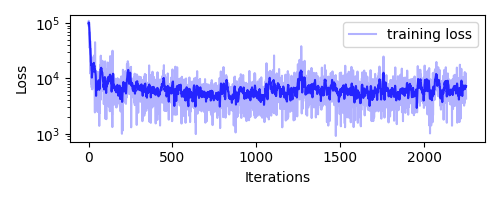

Epoch 1: Total Loss 4249.065, KL Loss 49.18, Feat. Loss 4052.36
Epoch 1: Total Loss 1695.857, KL Loss 28.26, Feat. Loss 1582.81
Epoch 1: Total Loss 14194.877, KL Loss 42.19, Feat. Loss 14026.10
Epoch 1: Total Loss 3140.707, KL Loss 35.65, Feat. Loss 2998.12
Epoch 1: Total Loss 9374.965, KL Loss 34.51, Feat. Loss 9236.90
Epoch 1: Total Loss 14336.322, KL Loss 37.68, Feat. Loss 14185.61
Epoch 1: Total Loss 9892.209, KL Loss 31.36, Feat. Loss 9766.77
Epoch 1: Total Loss 10624.775, KL Loss 53.99, Feat. Loss 10408.81
Epoch 1: Total Loss 9196.885, KL Loss 39.82, Feat. Loss 9037.59
Epoch 1 : 511.37, 585.94
Epoch 2: Total Loss 4670.678, KL Loss 47.14, Feat. Loss 4482.12
Epoch 2: Total Loss 4474.194, KL Loss 41.70, Feat. Loss 4307.40
Epoch 2: Total Loss 6480.000, KL Loss 42.51, Feat. Loss 6309.95
Epoch 2: Total Loss 6877.726, KL Loss 44.74, Feat. Loss 6698.77
Epoch 2: Total Loss 12803.357, KL Loss 48.57, Feat. Loss 12609.09
Epoch 2: Total Loss 8579.342, KL Loss 47.01, Feat. Loss 8391.31
Epoch 2

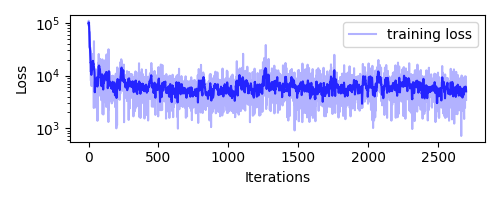

Epoch 1: Total Loss 11175.472, KL Loss 48.16, Feat. Loss 10982.83
Epoch 1: Total Loss 3542.284, KL Loss 32.25, Feat. Loss 3413.30
Epoch 1: Total Loss 7034.019, KL Loss 32.56, Feat. Loss 6903.79
Epoch 1: Total Loss 6595.326, KL Loss 53.71, Feat. Loss 6380.49
Epoch 1: Total Loss 3730.797, KL Loss 38.70, Feat. Loss 3575.99
Epoch 1: Total Loss 3135.999, KL Loss 34.88, Feat. Loss 2996.48
Epoch 1: Total Loss 5477.166, KL Loss 51.90, Feat. Loss 5269.56
Epoch 1: Total Loss 960.483, KL Loss 26.85, Feat. Loss 853.06
Epoch 1: Total Loss 8477.000, KL Loss 31.25, Feat. Loss 8352.00
Epoch 1 : 334.19, 342.32
Epoch 2: Total Loss 2323.722, KL Loss 29.54, Feat. Loss 2205.57
Epoch 2: Total Loss 6094.328, KL Loss 36.14, Feat. Loss 5949.76
Epoch 2: Total Loss 4763.884, KL Loss 40.74, Feat. Loss 4600.92
Epoch 2: Total Loss 4988.403, KL Loss 35.73, Feat. Loss 4845.47
Epoch 2: Total Loss 4631.299, KL Loss 41.09, Feat. Loss 4466.96
Epoch 2: Total Loss 5268.379, KL Loss 33.40, Feat. Loss 5134.79
Epoch 2: Total 

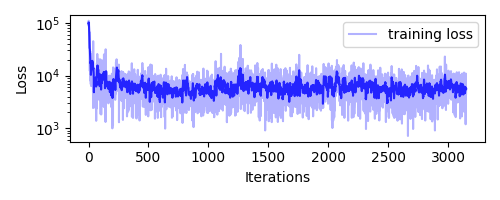

Epoch 1: Total Loss 5859.658, KL Loss 40.43, Feat. Loss 5697.94
Epoch 1: Total Loss 2870.882, KL Loss 31.34, Feat. Loss 2745.52
Epoch 1: Total Loss 2301.691, KL Loss 21.48, Feat. Loss 2215.77
Epoch 1: Total Loss 2922.309, KL Loss 37.56, Feat. Loss 2772.07
Epoch 1: Total Loss 8025.837, KL Loss 35.23, Feat. Loss 7884.90
Epoch 1: Total Loss 4012.162, KL Loss 31.69, Feat. Loss 3885.40
Epoch 1: Total Loss 4060.684, KL Loss 45.99, Feat. Loss 3876.72
Epoch 1: Total Loss 10089.563, KL Loss 34.77, Feat. Loss 9950.49
Epoch 1: Total Loss 5616.780, KL Loss 26.94, Feat. Loss 5509.04
Epoch 1 : 305.06, 253.79
Epoch 2: Total Loss 3782.587, KL Loss 31.23, Feat. Loss 3657.66
Epoch 2: Total Loss 3005.119, KL Loss 24.84, Feat. Loss 2905.76
Epoch 2: Total Loss 6258.536, KL Loss 29.52, Feat. Loss 6140.47
Epoch 2: Total Loss 5058.163, KL Loss 40.67, Feat. Loss 4895.47
Epoch 2: Total Loss 3313.428, KL Loss 31.79, Feat. Loss 3186.29
Epoch 2: Total Loss 6437.667, KL Loss 51.58, Feat. Loss 6231.33
Epoch 2: Total

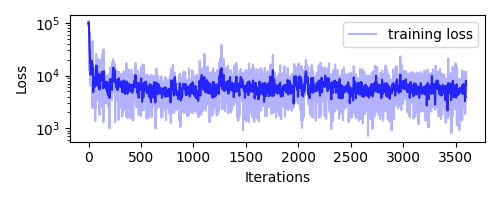

Epoch 1: Total Loss 5178.062, KL Loss 37.75, Feat. Loss 5027.05
Epoch 1: Total Loss 3743.363, KL Loss 23.87, Feat. Loss 3647.88
Epoch 1: Total Loss 7521.764, KL Loss 44.06, Feat. Loss 7345.53
Epoch 1: Total Loss 2873.579, KL Loss 26.62, Feat. Loss 2767.10
Epoch 1: Total Loss 5463.918, KL Loss 25.96, Feat. Loss 5360.08
Epoch 1: Total Loss 2505.646, KL Loss 27.19, Feat. Loss 2396.88
Epoch 1: Total Loss 7909.107, KL Loss 38.41, Feat. Loss 7755.49
Epoch 1: Total Loss 17317.812, KL Loss 39.64, Feat. Loss 17159.27
Epoch 1: Total Loss 11472.503, KL Loss 31.82, Feat. Loss 11345.21
Epoch 1 : 426.57, 341.49
Epoch 2: Total Loss 2076.517, KL Loss 31.07, Feat. Loss 1952.23
Epoch 2: Total Loss 4427.690, KL Loss 45.31, Feat. Loss 4246.45
Epoch 2: Total Loss 5902.536, KL Loss 38.58, Feat. Loss 5748.20
Epoch 2: Total Loss 4357.579, KL Loss 28.79, Feat. Loss 4242.43
Epoch 2: Total Loss 7974.119, KL Loss 38.92, Feat. Loss 7818.45
Epoch 2: Total Loss 9996.837, KL Loss 47.97, Feat. Loss 9804.94
Epoch 2: To

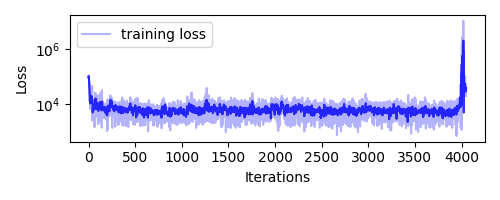

Epoch 1: Total Loss 26443.363, KL Loss 265.61, Feat. Loss 25380.93
Epoch 1: Total Loss 22272.594, KL Loss 247.80, Feat. Loss 21281.40
Epoch 1: Total Loss 36088.055, KL Loss 247.82, Feat. Loss 35096.77
Epoch 1: Total Loss 19242.162, KL Loss 224.98, Feat. Loss 18342.23
Epoch 1: Total Loss 10907.519, KL Loss 248.94, Feat. Loss 9911.76
Epoch 1: Total Loss 22953.848, KL Loss 220.26, Feat. Loss 22072.82
Epoch 1: Total Loss 20955.258, KL Loss 234.60, Feat. Loss 20016.86
Epoch 1: Total Loss 12868.265, KL Loss 218.14, Feat. Loss 11995.71
Epoch 1: Total Loss 21023.348, KL Loss 190.23, Feat. Loss 20262.43
Epoch 1 : 1285.03, 1313.96
Epoch 2: Total Loss 18245.844, KL Loss 230.67, Feat. Loss 17323.17
Epoch 2: Total Loss 11089.956, KL Loss 200.75, Feat. Loss 10286.96
Epoch 2: Total Loss 16480.699, KL Loss 205.95, Feat. Loss 15656.91
Epoch 2: Total Loss 19972.234, KL Loss 238.08, Feat. Loss 19019.93
Epoch 2: Total Loss 16068.396, KL Loss 227.31, Feat. Loss 15159.16
Epoch 2: Total Loss 16634.885, KL Lo

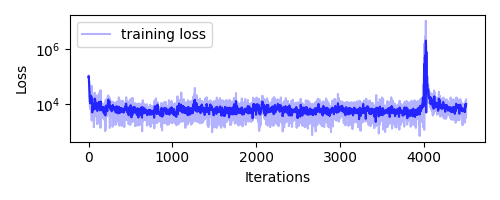

Epoch 1: Total Loss 9848.623, KL Loss 156.17, Feat. Loss 9223.92
Epoch 1: Total Loss 4264.582, KL Loss 150.99, Feat. Loss 3660.63
Epoch 1: Total Loss 3474.387, KL Loss 137.82, Feat. Loss 2923.09
Epoch 1: Total Loss 20704.684, KL Loss 161.82, Feat. Loss 20057.42
Epoch 1: Total Loss 5866.841, KL Loss 161.87, Feat. Loss 5219.38
Epoch 1: Total Loss 3444.926, KL Loss 147.94, Feat. Loss 2853.15
Epoch 1: Total Loss 5297.953, KL Loss 153.41, Feat. Loss 4684.29
Epoch 1: Total Loss 7914.942, KL Loss 170.58, Feat. Loss 7232.64
Epoch 1: Total Loss 12006.627, KL Loss 164.19, Feat. Loss 11349.86
Epoch 1 : 485.49, 366.68
Epoch 2: Total Loss 8460.607, KL Loss 150.23, Feat. Loss 7859.70
Epoch 2: Total Loss 6005.843, KL Loss 166.13, Feat. Loss 5341.31
Epoch 2: Total Loss 3304.598, KL Loss 136.79, Feat. Loss 2757.44
Epoch 2: Total Loss 5941.259, KL Loss 144.38, Feat. Loss 5363.75
Epoch 2: Total Loss 4097.371, KL Loss 152.79, Feat. Loss 3486.21
Epoch 2: Total Loss 8631.195, KL Loss 154.29, Feat. Loss 8014

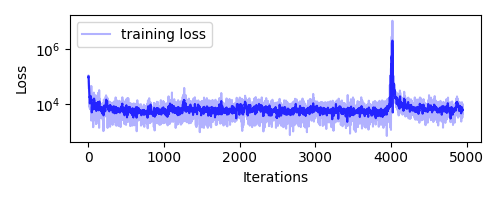

Epoch 1: Total Loss 9091.820, KL Loss 128.78, Feat. Loss 8576.68
Epoch 1: Total Loss 3706.666, KL Loss 146.28, Feat. Loss 3121.56
Epoch 1: Total Loss 3032.456, KL Loss 126.44, Feat. Loss 2526.71
Epoch 1: Total Loss 5205.640, KL Loss 136.81, Feat. Loss 4658.41
Epoch 1: Total Loss 4856.856, KL Loss 144.19, Feat. Loss 4280.09
Epoch 1: Total Loss 2165.368, KL Loss 109.44, Feat. Loss 1727.61
Epoch 1: Total Loss 6912.990, KL Loss 148.67, Feat. Loss 6318.31
Epoch 1: Total Loss 11418.039, KL Loss 131.15, Feat. Loss 10893.43
Epoch 1: Total Loss 3346.209, KL Loss 148.63, Feat. Loss 2751.67
Epoch 1 : 331.57, 303.55
Epoch 2: Total Loss 5511.438, KL Loss 108.87, Feat. Loss 5075.95
Epoch 2: Total Loss 4357.244, KL Loss 147.88, Feat. Loss 3765.71
Epoch 2: Total Loss 5521.709, KL Loss 135.01, Feat. Loss 4981.66
Epoch 2: Total Loss 5192.626, KL Loss 134.08, Feat. Loss 4656.31
Epoch 2: Total Loss 3717.709, KL Loss 155.18, Feat. Loss 3096.99
Epoch 2: Total Loss 6426.215, KL Loss 125.91, Feat. Loss 5922.5

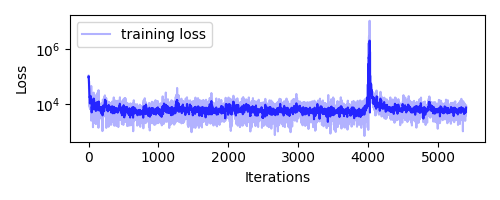

Epoch 1: Total Loss 3773.780, KL Loss 139.67, Feat. Loss 3215.10
Epoch 1: Total Loss 6816.646, KL Loss 145.59, Feat. Loss 6234.28
Epoch 1: Total Loss 2475.990, KL Loss 131.97, Feat. Loss 1948.13
Epoch 1: Total Loss 5925.875, KL Loss 114.64, Feat. Loss 5467.33
Epoch 1: Total Loss 2725.887, KL Loss 122.00, Feat. Loss 2237.90
Epoch 1: Total Loss 4482.729, KL Loss 143.01, Feat. Loss 3910.69
Epoch 1: Total Loss 19584.029, KL Loss 145.58, Feat. Loss 19001.72
Epoch 1: Total Loss 4418.926, KL Loss 144.14, Feat. Loss 3842.37
Epoch 1: Total Loss 4508.450, KL Loss 135.31, Feat. Loss 3967.20
Epoch 1 : 364.75, 280.17
Epoch 2: Total Loss 5506.584, KL Loss 132.37, Feat. Loss 4977.10
Epoch 2: Total Loss 4759.414, KL Loss 138.71, Feat. Loss 4204.56
Epoch 2: Total Loss 8823.490, KL Loss 153.01, Feat. Loss 8211.45
Epoch 2: Total Loss 5523.422, KL Loss 139.03, Feat. Loss 4967.30
Epoch 2: Total Loss 5869.682, KL Loss 141.16, Feat. Loss 5305.05
Epoch 2: Total Loss 9843.046, KL Loss 134.20, Feat. Loss 9306.2

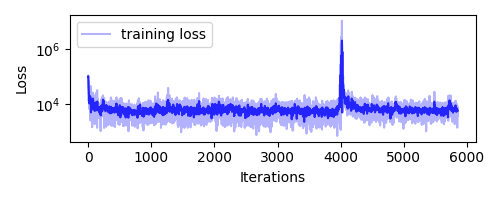

Epoch 1: Total Loss 3830.935, KL Loss 91.81, Feat. Loss 3463.68
Epoch 1: Total Loss 4987.335, KL Loss 98.47, Feat. Loss 4593.45
Epoch 1: Total Loss 1720.975, KL Loss 89.00, Feat. Loss 1364.97
Epoch 1: Total Loss 4828.803, KL Loss 107.05, Feat. Loss 4400.62
Epoch 1: Total Loss 9353.502, KL Loss 133.56, Feat. Loss 8819.26
Epoch 1: Total Loss 4685.638, KL Loss 93.89, Feat. Loss 4310.09
Epoch 1: Total Loss 3616.606, KL Loss 100.23, Feat. Loss 3215.67
Epoch 1: Total Loss 6437.074, KL Loss 104.88, Feat. Loss 6017.57
Epoch 1: Total Loss 5498.590, KL Loss 99.29, Feat. Loss 5101.45
Epoch 1 : 299.73, 301.80
Epoch 2: Total Loss 6274.952, KL Loss 91.77, Feat. Loss 5907.89
Epoch 2: Total Loss 6134.879, KL Loss 103.77, Feat. Loss 5719.80
Epoch 2: Total Loss 2979.017, KL Loss 94.71, Feat. Loss 2600.17
Epoch 2: Total Loss 6871.638, KL Loss 102.72, Feat. Loss 6460.78
Epoch 2: Total Loss 7382.611, KL Loss 84.35, Feat. Loss 7045.22
Epoch 2: Total Loss 2745.022, KL Loss 106.33, Feat. Loss 2319.70
Epoch 2:

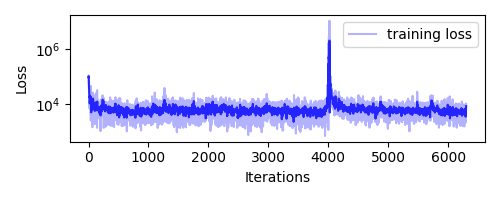

Epoch 1: Total Loss 4242.427, KL Loss 104.12, Feat. Loss 3825.94
Epoch 1: Total Loss 10721.477, KL Loss 111.09, Feat. Loss 10277.12
Epoch 1: Total Loss 2818.542, KL Loss 100.48, Feat. Loss 2416.62
Epoch 1: Total Loss 4041.729, KL Loss 96.55, Feat. Loss 3655.54
Epoch 1: Total Loss 6562.074, KL Loss 117.40, Feat. Loss 6092.45
Epoch 1: Total Loss 4647.837, KL Loss 88.19, Feat. Loss 4295.07
Epoch 1: Total Loss 5509.905, KL Loss 112.49, Feat. Loss 5059.95
Epoch 1: Total Loss 2750.415, KL Loss 96.74, Feat. Loss 2363.45
Epoch 1: Total Loss 5047.757, KL Loss 108.01, Feat. Loss 4615.73
Epoch 1 : 308.95, 290.49
Epoch 2: Total Loss 2744.718, KL Loss 102.12, Feat. Loss 2336.25
Epoch 2: Total Loss 3392.165, KL Loss 107.13, Feat. Loss 2963.66
Epoch 2: Total Loss 3248.644, KL Loss 102.57, Feat. Loss 2838.37
Epoch 2: Total Loss 11163.613, KL Loss 93.61, Feat. Loss 10789.17
Epoch 2: Total Loss 4603.354, KL Loss 95.01, Feat. Loss 4223.32
Epoch 2: Total Loss 2922.762, KL Loss 94.13, Feat. Loss 2546.24
Ep

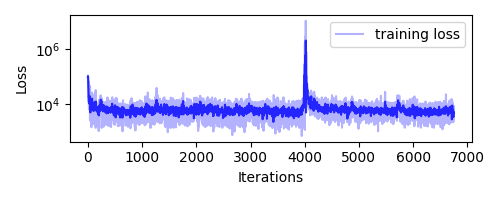

Epoch 1: Total Loss 3556.584, KL Loss 110.54, Feat. Loss 3114.44
Epoch 1: Total Loss 2674.573, KL Loss 73.72, Feat. Loss 2379.69
Epoch 1: Total Loss 4170.715, KL Loss 89.25, Feat. Loss 3813.72
Epoch 1: Total Loss 2604.975, KL Loss 90.93, Feat. Loss 2241.24
Epoch 1: Total Loss 3095.458, KL Loss 68.92, Feat. Loss 2819.79
Epoch 1: Total Loss 7422.440, KL Loss 98.38, Feat. Loss 7028.92
Epoch 1: Total Loss 3738.605, KL Loss 86.49, Feat. Loss 3392.63
Epoch 1: Total Loss 6068.792, KL Loss 85.95, Feat. Loss 5724.98
Epoch 1: Total Loss 7919.750, KL Loss 104.51, Feat. Loss 7501.69
Epoch 1 : 275.01, 233.66
Epoch 2: Total Loss 4181.439, KL Loss 106.01, Feat. Loss 3757.39
Epoch 2: Total Loss 2878.432, KL Loss 90.36, Feat. Loss 2516.99
Epoch 2: Total Loss 5033.613, KL Loss 81.08, Feat. Loss 4709.28
Epoch 2: Total Loss 6482.723, KL Loss 101.96, Feat. Loss 6074.90
Epoch 2: Total Loss 4280.425, KL Loss 115.62, Feat. Loss 3817.96
Epoch 2: Total Loss 2811.805, KL Loss 80.56, Feat. Loss 2489.58
Epoch 2: T

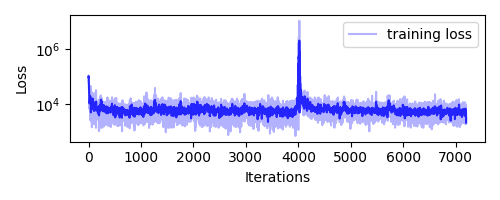

Epoch 1: Total Loss 3938.479, KL Loss 98.33, Feat. Loss 3545.15
Epoch 1: Total Loss 2804.265, KL Loss 90.93, Feat. Loss 2440.56
Epoch 1: Total Loss 2898.316, KL Loss 77.28, Feat. Loss 2589.18
Epoch 1: Total Loss 5337.363, KL Loss 82.28, Feat. Loss 5008.24
Epoch 1: Total Loss 5242.131, KL Loss 89.21, Feat. Loss 4885.30
Epoch 1: Total Loss 10129.885, KL Loss 81.58, Feat. Loss 9803.57
Epoch 1: Total Loss 8702.333, KL Loss 96.26, Feat. Loss 8317.28
Epoch 1: Total Loss 4361.261, KL Loss 88.02, Feat. Loss 4009.17
Epoch 1: Total Loss 3357.734, KL Loss 103.49, Feat. Loss 2943.76
Epoch 1 : 311.81, 272.58
Epoch 2: Total Loss 3419.492, KL Loss 78.79, Feat. Loss 3104.31
Epoch 2: Total Loss 2897.924, KL Loss 88.09, Feat. Loss 2545.56
Epoch 2: Total Loss 4561.473, KL Loss 90.28, Feat. Loss 4200.34
Epoch 2: Total Loss 5096.650, KL Loss 85.04, Feat. Loss 4756.48
Epoch 2: Total Loss 5119.184, KL Loss 99.61, Feat. Loss 4720.74
Epoch 2: Total Loss 1876.082, KL Loss 103.91, Feat. Loss 1460.43
Epoch 2: Tot

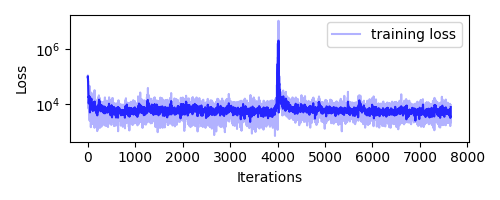

Epoch 1: Total Loss 5258.694, KL Loss 97.69, Feat. Loss 4867.93
Epoch 1: Total Loss 4753.048, KL Loss 94.05, Feat. Loss 4376.84
Epoch 1: Total Loss 5056.202, KL Loss 68.92, Feat. Loss 4780.51
Epoch 1: Total Loss 7907.307, KL Loss 75.38, Feat. Loss 7605.80
Epoch 1: Total Loss 3994.957, KL Loss 85.84, Feat. Loss 3651.59
Epoch 1: Total Loss 4620.457, KL Loss 80.48, Feat. Loss 4298.55
Epoch 1: Total Loss 2855.836, KL Loss 79.36, Feat. Loss 2538.41
Epoch 1: Total Loss 3378.717, KL Loss 89.05, Feat. Loss 3022.50
Epoch 1: Total Loss 4015.469, KL Loss 94.87, Feat. Loss 3635.99
Epoch 1 : 278.94, 288.78
Epoch 2: Total Loss 5072.033, KL Loss 98.42, Feat. Loss 4678.34
Epoch 2: Total Loss 3385.827, KL Loss 91.21, Feat. Loss 3020.98
Epoch 2: Total Loss 2566.883, KL Loss 71.66, Feat. Loss 2280.23
Epoch 2: Total Loss 4864.095, KL Loss 95.78, Feat. Loss 4480.98
Epoch 2: Total Loss 2790.823, KL Loss 93.38, Feat. Loss 2417.30
Epoch 2: Total Loss 7068.562, KL Loss 68.26, Feat. Loss 6795.53
Epoch 2: Total 

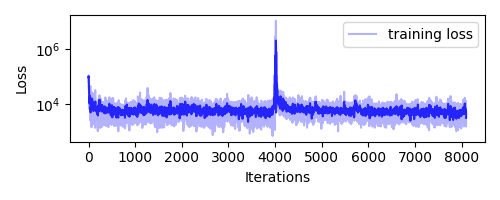

Epoch 1: Total Loss 3455.235, KL Loss 80.11, Feat. Loss 3134.81
Epoch 1: Total Loss 2905.635, KL Loss 63.56, Feat. Loss 2651.40
Epoch 1: Total Loss 2393.098, KL Loss 80.45, Feat. Loss 2071.31
Epoch 1: Total Loss 11349.006, KL Loss 91.72, Feat. Loss 10982.12
Epoch 1: Total Loss 3246.406, KL Loss 71.63, Feat. Loss 2959.88
Epoch 1: Total Loss 3524.720, KL Loss 71.64, Feat. Loss 3238.16
Epoch 1: Total Loss 6640.236, KL Loss 94.97, Feat. Loss 6260.37
Epoch 1: Total Loss 2339.594, KL Loss 92.29, Feat. Loss 1970.43
Epoch 1: Total Loss 12294.401, KL Loss 77.08, Feat. Loss 11986.09
Epoch 1 : 320.99, 215.95
Epoch 2: Total Loss 2453.196, KL Loss 52.15, Feat. Loss 2244.58
Epoch 2: Total Loss 6536.515, KL Loss 86.49, Feat. Loss 6190.55
Epoch 2: Total Loss 6905.316, KL Loss 85.60, Feat. Loss 6562.91
Epoch 2: Total Loss 2735.953, KL Loss 66.20, Feat. Loss 2471.14
Epoch 2: Total Loss 5669.244, KL Loss 84.16, Feat. Loss 5332.59
Epoch 2: Total Loss 3513.303, KL Loss 89.96, Feat. Loss 3153.46
Epoch 2: To

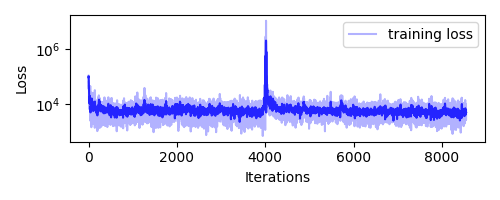

Epoch 1: Total Loss 2130.057, KL Loss 53.61, Feat. Loss 1915.61
Epoch 1: Total Loss 3029.760, KL Loss 74.56, Feat. Loss 2731.54
Epoch 1: Total Loss 4982.939, KL Loss 52.41, Feat. Loss 4773.31
Epoch 1: Total Loss 7119.459, KL Loss 81.89, Feat. Loss 6791.91
Epoch 1: Total Loss 1521.194, KL Loss 57.45, Feat. Loss 1291.38
Epoch 1: Total Loss 2626.878, KL Loss 67.83, Feat. Loss 2355.57
Epoch 1: Total Loss 9234.127, KL Loss 85.58, Feat. Loss 8891.81
Epoch 1: Total Loss 6246.909, KL Loss 65.38, Feat. Loss 5985.38
Epoch 1: Total Loss 3323.579, KL Loss 72.07, Feat. Loss 3035.28
Epoch 1 : 268.10, 207.72
Epoch 2: Total Loss 4778.807, KL Loss 72.23, Feat. Loss 4489.89
Epoch 2: Total Loss 1922.824, KL Loss 66.88, Feat. Loss 1655.32
Epoch 2: Total Loss 1749.144, KL Loss 62.26, Feat. Loss 1500.11
Epoch 2: Total Loss 4699.019, KL Loss 58.33, Feat. Loss 4465.71
Epoch 2: Total Loss 7650.178, KL Loss 76.75, Feat. Loss 7343.17
Epoch 2: Total Loss 2158.076, KL Loss 66.50, Feat. Loss 1892.08
Epoch 2: Total 

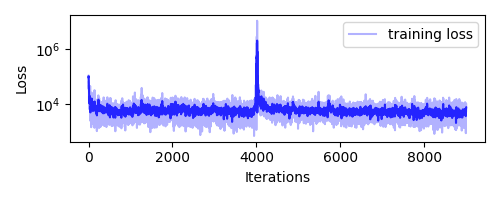

./saves/default_run_default_20240227-143858/*.png
image_arrays shape: (20, 1200, 2100, 4)


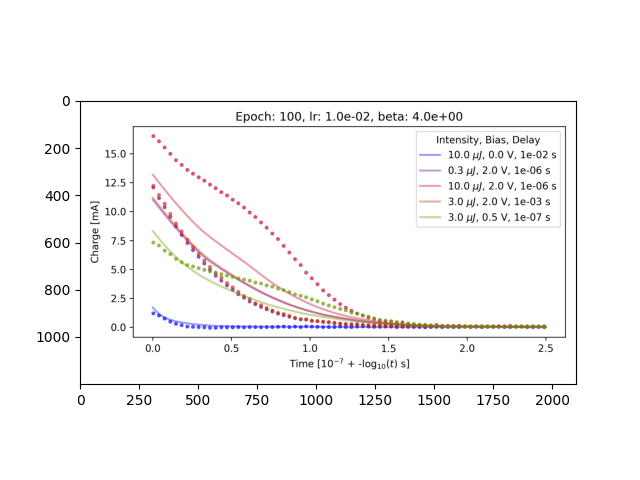

{'nhidden': 128,
 'rnn_nhidden': 32,
 'obs_dim': 1,
 'latent_dim': 16,
 'lr': 0.01,
 'n_batch': 16,
 'beta': 4,
 'optim': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ),
 'device': 'cpu',
 'func': LatentODEfunc(
   (elu): ELU(alpha=1.0, inplace=True)
   (fci): Linear(in_features=16, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=128, bias=True)
   (fco): Linear(in_features=128, out_features=16, bias=True)
 ),
 'rec': RecognitionRNN(
   (i2h): Linear(in_features=33, out_features=32, bias=True)
   (h2o): Linear(in_features=32, out_features=32, bias=True)
 ),
 'dec': Decoder(
   (relu): ReLU(inplace=True)
   (fc1): Linear(in_features=16, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=1, bias=True)
 ),
 'total_epochs_train': 1000,
 'epochs_per_train':

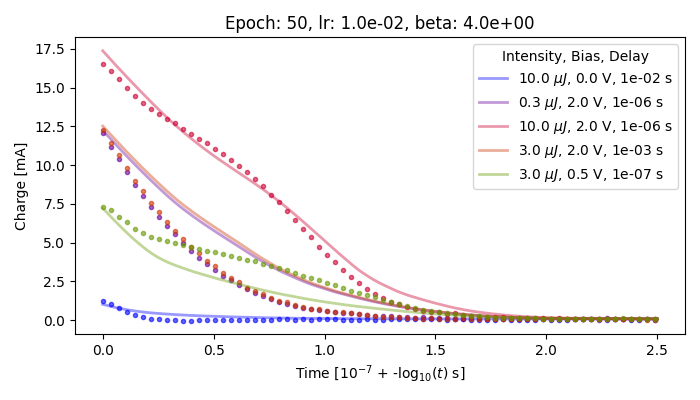

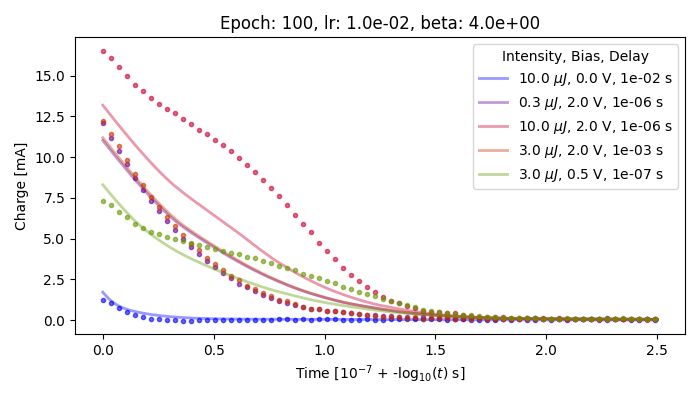

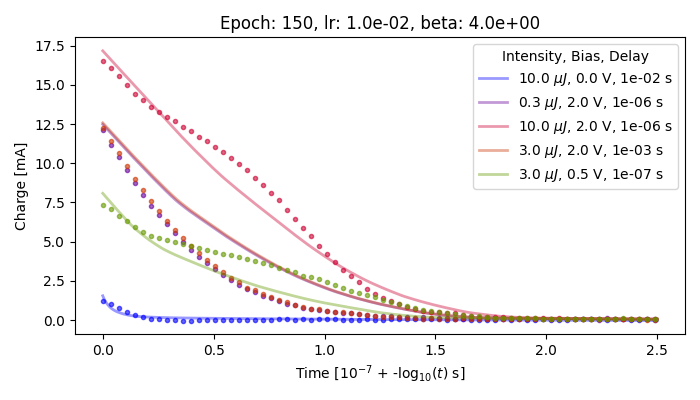

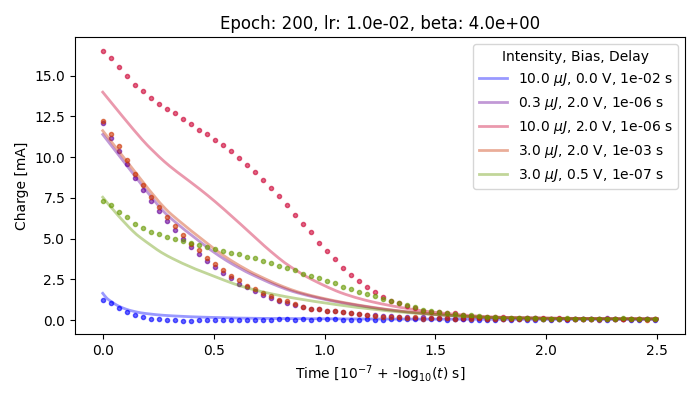

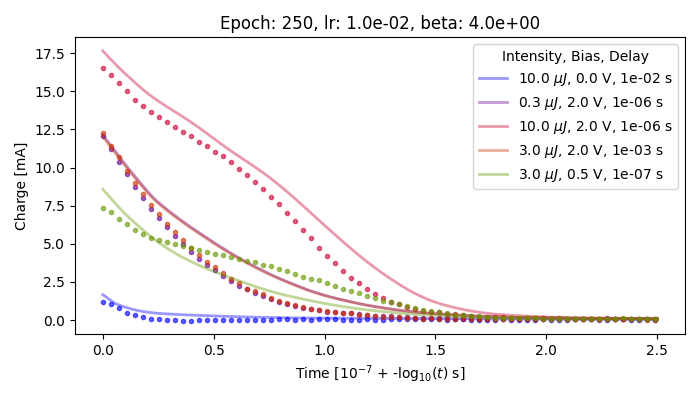

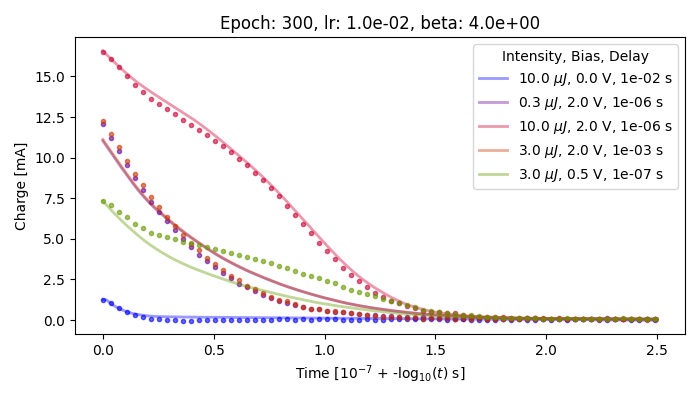

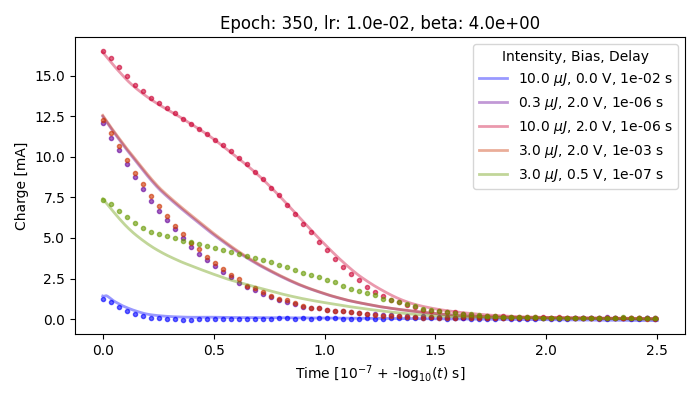

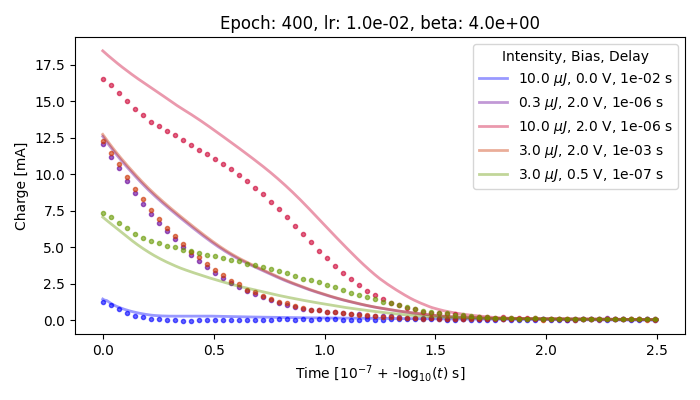

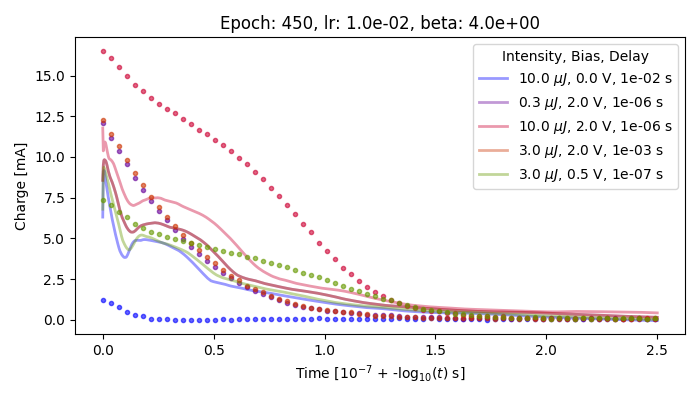

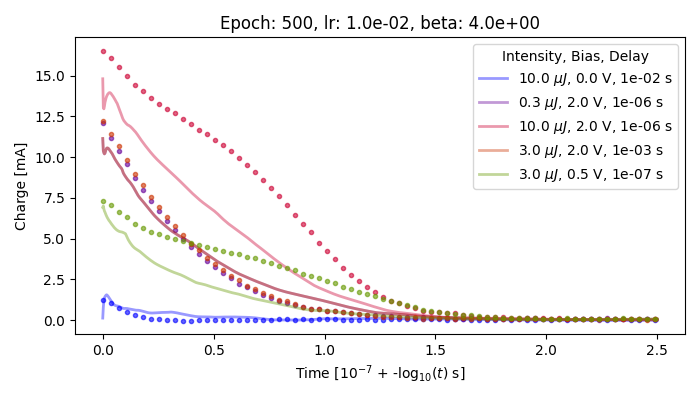

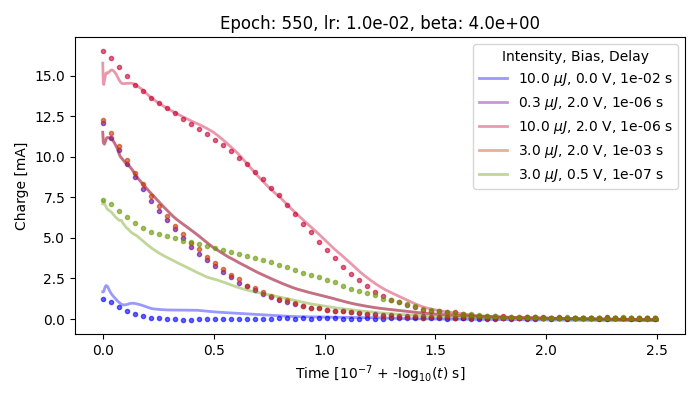

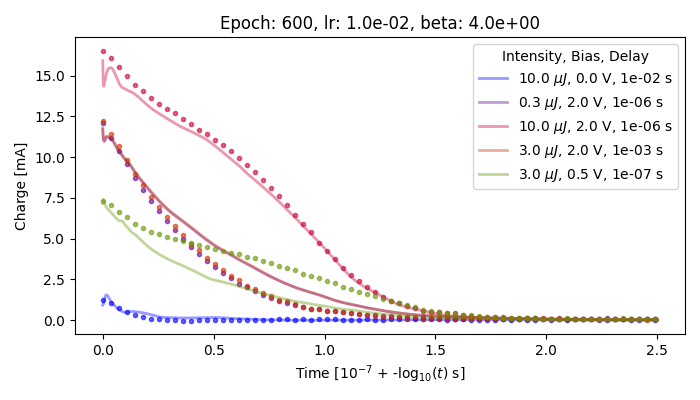

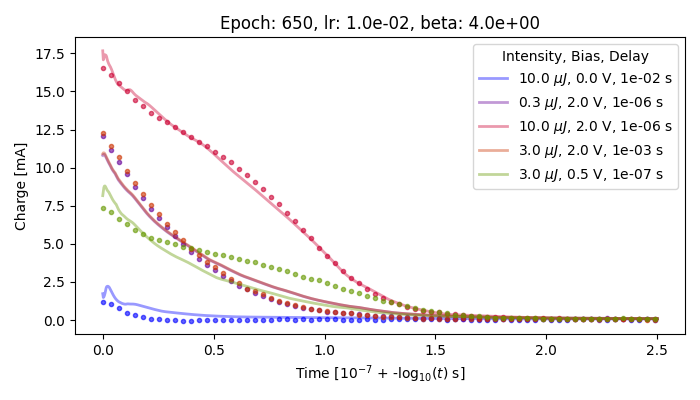

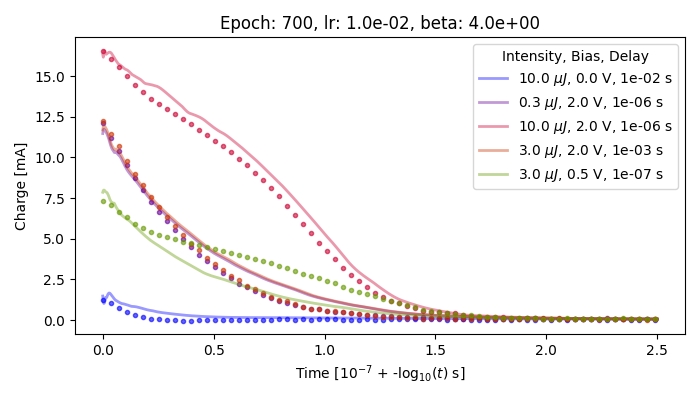

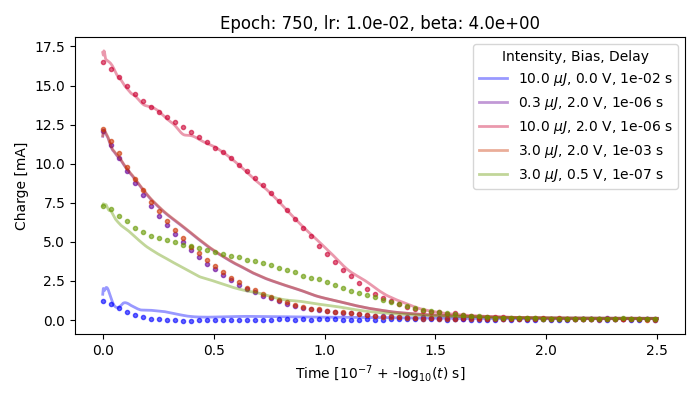

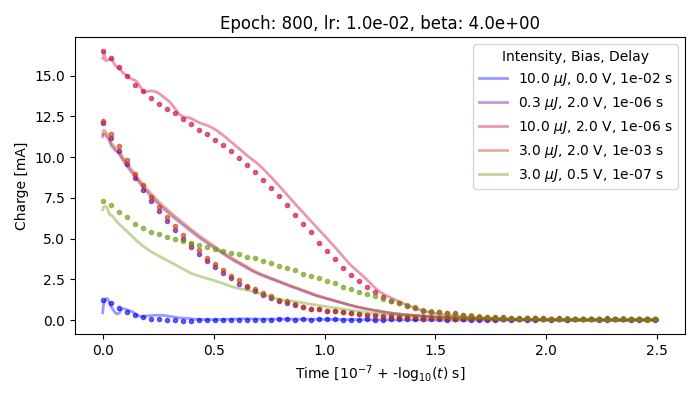

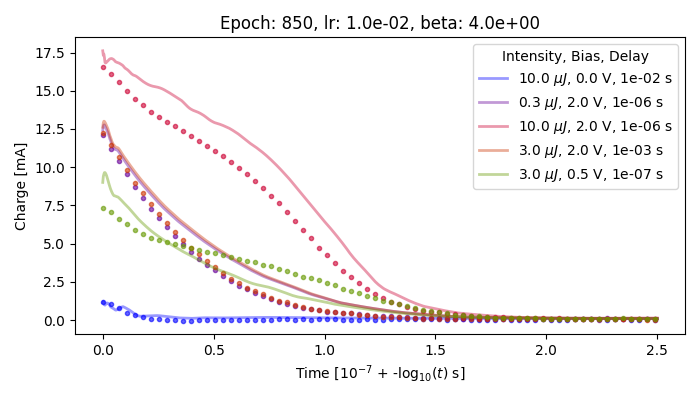

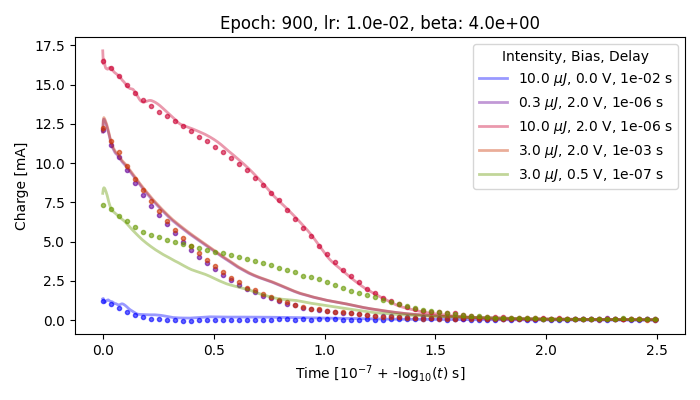

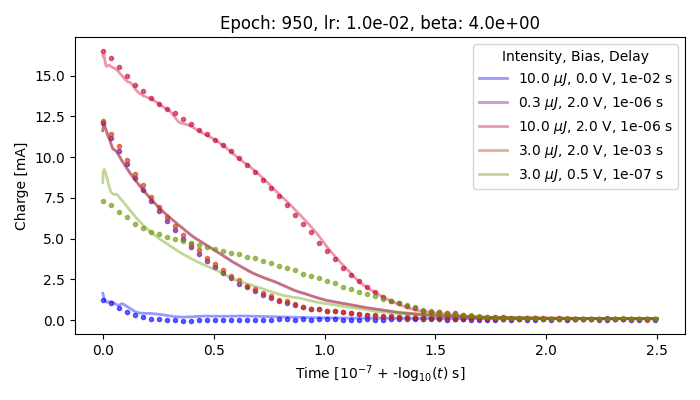

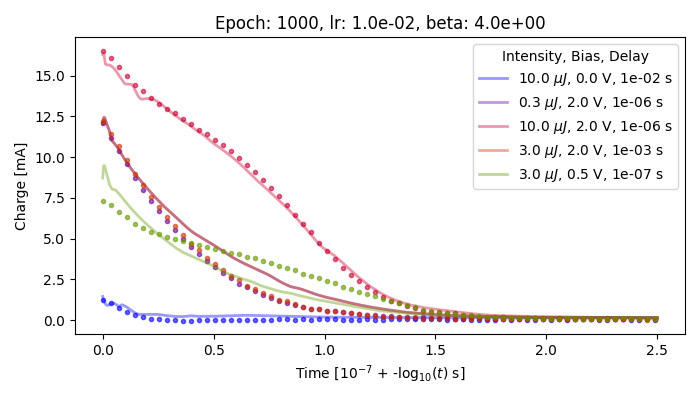

In [29]:
run_and_save(model_params, dataset)

## 3.4. Others

In [42]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 369A-61BF

 Directory of c:\Users\z5183876\Documents\GitHub\ML_charge_modeling\nbks

19/02/2024  11:27 AM    <DIR>          .
19/02/2024  11:46 AM    <DIR>          ..
19/02/2024  11:27 AM    <DIR>          gifs
20/02/2024  08:27 AM         4,504,746 parameter_tuning.ipynb
19/02/2024  11:27 AM           498,255 ray.ipynb
20/02/2024  08:38 AM    <DIR>          saves
19/02/2024  11:27 AM         2,196,743 trce-lode-rebuild.ipynb
19/02/2024  11:27 AM           202,975 trce-process-updt.ipynb
               4 File(s)      7,402,719 bytes
               4 Dir(s)  343,308,521,472 bytes free


In [43]:
#interpret grid search results

dataframe1 = pd.read_excel(".\saves\grid_seach\search1\excel_output\summary.xlsx")
 
# print(dataframe1)
data_dict = dataframe1.to_dict()

size = len(data_dict['Unnamed: 0'])
indexes = data_dict['Unnamed: 0']
learning_rates = data_dict['learning rate']
n_batchs = data_dict['n_batch']
latent_dims = data_dict['latent_dim']
betas = data_dict['beta']
lowest_loss = data_dict['lowest_loss']



minimum_loss = min(lowest_loss.values())
minimum_loss_index = list(lowest_loss.values()).index(minimum_loss)
print(f"minimum_loss: {minimum_loss} at index: {minimum_loss_index} with learning rate: {learning_rates[minimum_loss_index]}, n_batch: {n_batchs[minimum_loss_index]}, latent_dim: {latent_dims[minimum_loss_index]}, beta: {betas[minimum_loss_index]}")

lowest_loss_sorted = sorted(list(lowest_loss.values()))[:5]      #gets the 5 lowest loss values
lowest_loss_index = [list(lowest_loss.values()).index(i) for i in lowest_loss_sorted]  #gets the indexes of the 5 lowest loss values
print("\n Analysing the 5 lowest values: \n")
for i in lowest_loss_index:
    print(f"loss: {lowest_loss[i]} at index: {i} with learning rate: {learning_rates[i]}, n_batch: {n_batchs[i]}, latent_dim: {latent_dims[i]}, beta: {betas[i]}")

print("\n analysing average loss of each characterstic \n")

#get unique values of each characteristic
unique_learning_rates = list(set(learning_rates.values()))
unique_n_batchs = list(set(n_batchs.values()))
unique_latent_dims = list(set(latent_dims.values()))
unique_betas = list(set(betas.values()))\

best_learning_rate = unique_learning_rates[0]
max_loss = max(lowest_loss.values())

temp_min = max_loss
temp_avg = max_loss
best_learning_rate_min = 0
best_learning_rate_avg = 0
for lr in unique_learning_rates:
    lr_losses = [lowest_loss[i] for i in range(size) if learning_rates[i] == lr]
    print(f"\nanalysing learning rate: {lr}\n")
    minimum = min(lr_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(lr_losses, 25)}")
    mean = sum(lr_losses)/len(lr_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(lr_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_learning_rate_min = lr
    if mean < temp_avg:
        temp_avg = mean
        best_learning_rate_avg = lr
print(f"\nbest learning rate for minimum loss: {best_learning_rate_min}")
print(f"best learning rate for average loss: {best_learning_rate_avg}\n")
    
temp_min = max_loss
temp_avg = max_loss
best_n_batch_min = 0
best_n_batch_avg = 0
for nb in unique_n_batchs:
    nb_losses = [lowest_loss[i] for i in range(size) if n_batchs[i] == nb]
    print(f"\nanalysing n_batch: {nb}\n")
    minimum = min(nb_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(nb_losses, 25)}")
    mean = sum(nb_losses)/len(nb_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(nb_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_n_batch_min = nb
    if mean < temp_avg:
        temp_avg = mean
        best_n_batch_avg = nb
print(f"\nbest n_batch for minimum loss: {best_n_batch_min}")
print(f"best n_batch for average loss: {best_n_batch_avg}\n")

temp_min = max_loss
temp_avg = max_loss
best_latent_dim_min = 0
best_latent_dim_avg = 0
for ld in unique_latent_dims:
    ld_losses = [lowest_loss[i] for i in range(size) if latent_dims[i] == ld]
    print(f"\nanalysing latent_dim: {ld}\n")
    minimum = min(ld_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(ld_losses, 25)}")
    mean = sum(ld_losses)/len(ld_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(ld_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_latent_dim_min = ld
    if mean < temp_avg:
        temp_avg = mean
        best_latent_dim_avg = ld
print(f"\nbest latent_dim for minimum loss: {best_latent_dim_min}")
print(f"best latent_dim for average loss: {best_latent_dim_avg}\n")


temp_min = max_loss
temp_avg = max_loss
best_beta_min = 0
best_beta_avg = 0
for b in unique_betas:
    b_losses = [lowest_loss[i] for i in range(size) if betas[i] == b]
    print(f"\nanalysing beta: {b}\n")
    minimum = min(b_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(b_losses, 25)}")
    mean = sum(b_losses)/len(b_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(b_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_beta_min = b
    if mean < temp_avg:
        temp_avg = mean
        best_beta_avg = b
print(f"\nbest beta for minimum loss: {best_beta_min}")
print(f"best beta for average loss: {best_beta_avg}\n")

minimum_loss: 8813.390625 at index: 20 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.001

 Analysing the 5 lowest values: 

loss: 8813.390625 at index: 20 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.001
loss: 13821.625 at index: 9 with learning rate: 0.01, n_batch: 16, latent_dim: 2, beta: 4.0
loss: 14612.8681640625 at index: 16 with learning rate: 0.01, n_batch: 16, latent_dim: 8, beta: 0.5
loss: 15689.7685546875 at index: 46 with learning rate: 0.005, n_batch: 16, latent_dim: 16, beta: 0.5
loss: 16143.001953125 at index: 21 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.5

 analysing average loss of each characterstic 


analysing learning rate: 0.01

minimum loss: 8813.390625
25th percentile: 17082.22265625
average loss: 36204.0650390625
75th percentile loss: 51540.1328125

analysing learning rate: 0.005

minimum loss: 15689.7685546875
25th percentile: 18697.85546875
average loss: 33086.3885546875
75th percentile loss: 23377.257812

In [44]:
# change summary avg loss -> 25%
# summary to include what the bads are.
# take the interesting examples/trends and look into them
# implement MSE/KL graphs.

# implement time-cutoff and run interesting trends at 200 epochs
# tweak/look into a or f tolerance

# start working on report. 


# loss: 13821.625 at index: 9 with learning rate: 0.01, n_batch: 16, latent_dim: 2, beta: 4.0

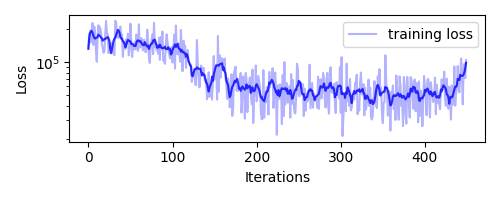

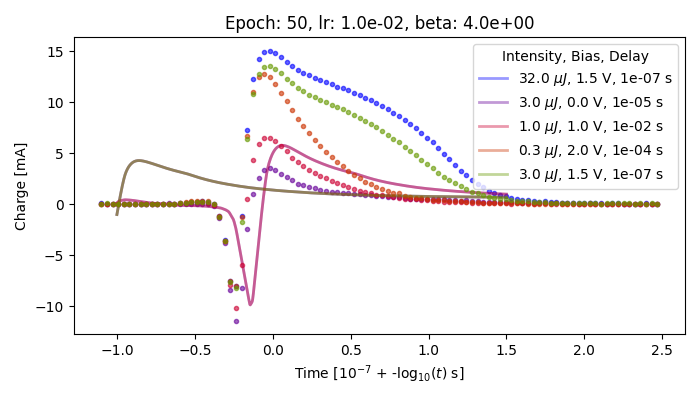

In [45]:
plot_training_loss(model_params)
display_random_fit(model_params, dataset)

(150, 2) (150, 1000, 2)


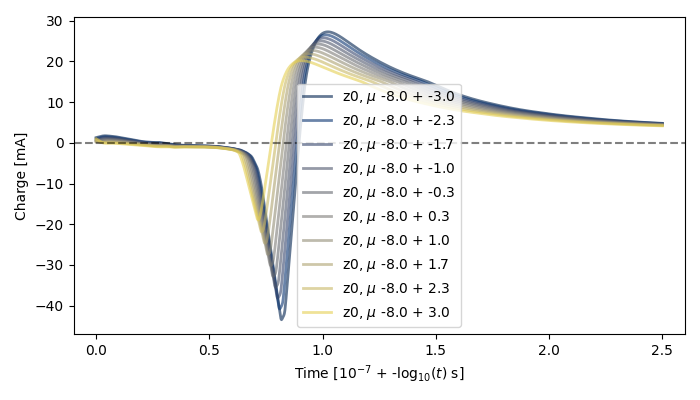

(150, 2) (150, 1000, 2)


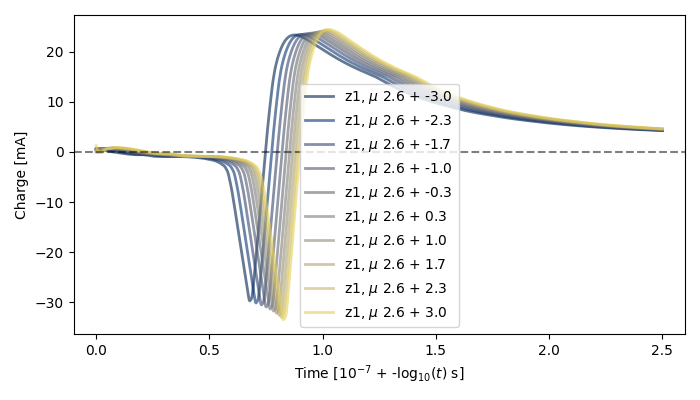

In [46]:
sweep_latent_adaptives(model_params, dataset)

./saves/lr_0.01_nb_16_ld_2_b_4_default_20240220-083836/*.png
image_arrays shape: (10, 1200, 2100, 4)


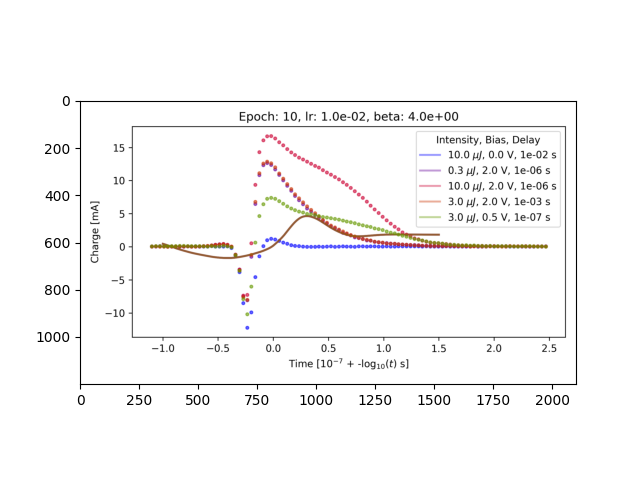

In [47]:
compile_learning_gif(model_params)

select fixed subset to sample in gif
save the model
record params
plot param changes along with gif
remove 1 second bias
